# Import libraries

In [1]:
# from surprise import BaselineOnly
from surprise import NMF, SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold

from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import os
# import sys
import math
import statistics
import collections

import sklearn as sk
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import pandas as pd

import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

import datetime
from datetime import datetime
from time import time
import timeit

from tqdm import tqdm
# from multiprocessing import Pool


Splitting the data using the *userfixed* method, where 80% of each user's data goes to training and the rest to testing set. Surprises split method is randomly. Their method is extended below.

In [2]:
from platform import python_version

print(python_version())

3.8.18


# Rating Data class 'userfixed' data split method.

In [3]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        # self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or inner id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        # if len(lf_sp) != 4:
        #     raise Exception('''Bad line format!
        #     line_format should be space-separated and it should always specified by 
        #     "user item rating timestamp" with any order!''')
        user_idx = -1
        item_idxa = -1
        rating_idx = -1
        # timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
            # elif lf_sp[c] == 'timestamp':
            #     timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating/timestamp) separated by sep!')
        
        # return user_idx, item_idx, rating_idx, timestamp_idx
        return user_idx, item_idx, rating_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    # def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating'):
        
        # user_fmt_idx, item_fmt_idx, rating_fmt_idx, timestamp_fmt_idx = self.__get_line_format_indices(line_format)
        user_fmt_idx, item_fmt_idx, rating_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
        # timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
            # timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
            # timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        '''note that raw ids are in STRING format, and the iid in INTEGER format!'''
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
            
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
            
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
            
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
        # self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
            # self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        item_ratings = []
        for item_iid in range(self.item_n):
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
#                 print(test_len, len_u)
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
#                 print(len(train_set_u))
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('\nNumber of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d\n' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests
    

# Data Import

In [4]:
all_df = pd.read_csv('Data/df_modcloth.csv', 
                     sep=",", header=0, engine="python")

In [5]:
all_df[all_df['user_attr']=='Small'].shape

(73161, 12)

In [6]:
all_df[all_df['user_attr']=='Large'].shape

(18365, 12)

In [7]:
df = all_df[['user_id', 'item_id', 'rating']]
df.columns = ['user', 'item', 'rating']

user = all_df[['user_id', 'user_attr']]
# drop multiple entries for one user
user = user.drop_duplicates(subset=['user_id'])
user.columns = ['id', 'attr']
user = user.replace(['Small', 'Large'], ['S', 'L'])

**<font color='red'>Important change: filtering out users without gender information!!!</font>** Causing the number of ratings to reduce from 99893 to 91525.

In [8]:
# filter out users without gender information
user = user.dropna()
df = df[df['user'].isin(user['id'])]

In [9]:
all_df.shape[0]

99893

In [10]:
df.shape[0]

91525

## Dimensionality Reduction - ncore

**<font color='red'>Change: n core changed from 5 to 3!!!</font>**

In [11]:
n_core = 3

In [12]:
f_name = 'f_%i_core'%n_core
f_name

'f_3_core'

In [13]:
# To reduce the dimensionality of the dataset,
# we will filter out rarely rated movies and rarely rating users

min_ratings = n_core
min_user_ratings = n_core

init_df = df
init_shp = df.shape[0]
filt_shp = 0.0

while True:

    filter_items = init_df['item'].value_counts() > min_ratings
    filter_items = filter_items[filter_items == True].index.tolist()

    filter_users = init_df['user'].value_counts() > min_user_ratings
    filter_users = filter_users[filter_users == True].index.tolist()

    filt_df = init_df[(init_df['item'].isin(filter_items)) & (init_df['user'].isin(filter_users))]

    print('The original data frame shape:\t{}'.format(init_df.shape))
    print('The new data frame shape:\t{}'.format(filt_df.shape))
    print()
    
    init_shp = init_df.shape[0]
    filt_shp = filt_df.shape[0]
    
    # print(init_shp, filt_shp)
    
    if (init_shp == filt_shp):
        break
    
    init_df = filt_df

    
#------------------------------------------------------------
'Updating the df to its filtered version'
'Now filt-df is called df.' 
df = filt_df
print(filt_df.shape)
print(df.head())

print()
print('#users: ', np.unique(df['user']).shape)
print('#items: ', np.unique(df['item']).shape)

The original data frame shape:	(91525, 3)
The new data frame shape:	(43383, 3)

The original data frame shape:	(43383, 3)
The new data frame shape:	(43086, 3)

The original data frame shape:	(43086, 3)
The new data frame shape:	(43047, 3)

The original data frame shape:	(43047, 3)
The new data frame shape:	(43041, 3)

The original data frame shape:	(43041, 3)
The new data frame shape:	(43041, 3)

(43041, 3)
     user  item  rating
0    Alex  7443       4
2   Robyn  7443       4
4   tasha  7443       4
6     Kim  7443       2
8  Elissa  7443       4

#users:  (3679,)
#items:  (825,)


**<font color='red'>Difference: number of ratings reduced by 2/3 after dimension reduction!!!</font>**

### Saving the filtered rating data & re-reading it again

In [14]:
df.to_csv('./filtered_mc_%icore.csv'%n_core, sep=',', index=False)

In [15]:
df = pd.read_csv('./filtered_mc_%icore.csv'%n_core, sep=',')
print(df.shape)
df.head()

(43041, 3)


,user,item,rating
0,Alex,7443,4
1,Robyn,7443,4
2,tasha,7443,4
3,Kim,7443,2
4,Elissa,7443,4


## Data Preprocessing (pro & unpro)

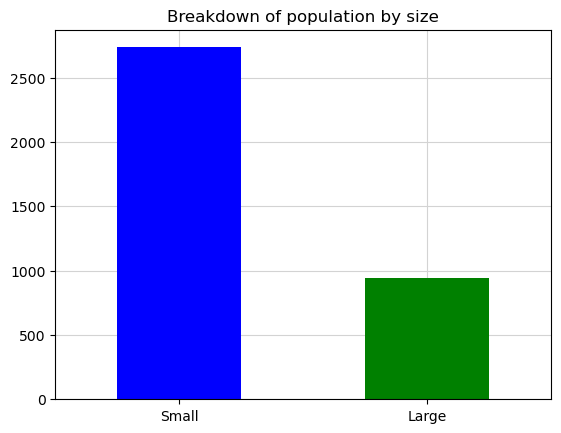

In [16]:
# Filtering the user.dat file based on the ncore process - not sure if we need this or not
user = user[user['id'].isin(np.unique(df['user']))]
user.shape


#  We consider "size" as the sensitive attribute.
    # L is the protected value and S is the unprotected value.

#------------------------------------------------------------
'The protected and the unprotected'

user['is_pro'] = 0
for i, row in user.iterrows():
    if row['attr'] == 'L':
        user.loc[i,'is_pro'] = 1
        
# user.head(3)

#------------------------------------------------------------
'preliminary stats'

breakbygender = pd.value_counts(user['is_pro'].values,sort=False)
# print(breakbygender,'\n')

ax = breakbygender[[0,1]].plot(kind='bar', title='Breakdown of population by size', color=['b', 'g'])
ax.grid(True, color='lightgray', linestyle='-')
ax.set_xticks([0,1])
ax.set_xticklabels(['Small', 'Large'], rotation='horizontal')
ax.set_axisbelow(True)

#------------------------------------------------------------



In [17]:
breakbygender[[0,1]]

0    2736
1     943
Name: count, dtype: int64

### original ratio of large to small 

In [18]:
breakbygender.get(1) / (breakbygender.get(0) + breakbygender.get(1))

0.2563196520793694

In [19]:
breakbygender.get(1) / breakbygender.get(0)

0.3446637426900585

### number of ratings by s & l in dataset (whole)

In [20]:
user.head()

,id,attr,is_pro
0,Alex,S,0
2,Robyn,S,0
4,tasha,S,0
6,Kim,S,0
8,Elissa,S,0


In [21]:
user[(user['id'] == 'Alex') & (user['attr'] == 'S')]

,id,attr,is_pro
0,Alex,S,0


In [22]:
np.any((user['id'] == 'Alex') & (user['attr'] == 'S'))

True

In [23]:
l_rating_count = 0 
s_rating_count = 0

for a, b in df.groupby('user'):
    if np.any((user['id'] == a) & (user['attr'] == 'L')):
        l_rating_count += len(b)
    else:
        s_rating_count += len(b)
        
print(l_rating_count)
print(s_rating_count)
        

6526
36515


In [24]:
# probability of rating by a woman
l_rating_count/(l_rating_count+s_rating_count)


0.15162287121581747

In [25]:
# user.head()

## Rating Distribution 

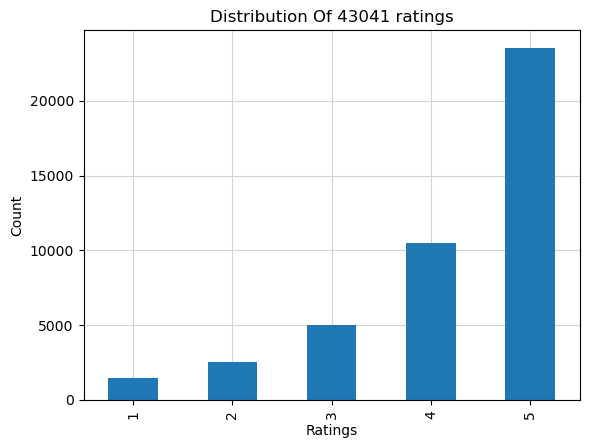

In [26]:
data = df['rating'].value_counts().sort_index(ascending=True)

ax = data.plot(kind='bar', title='Distribution Of {} ratings'.format(df.shape[0]))
ax.grid(True, color='lightgray', linestyle='-')
# ax.set_xticks([0,1,2,3,4])
ax.set_xlabel('Ratings')
ax.set_ylabel('Count')
ax.set_axisbelow(True)


In [27]:
data

rating
1     1478
2     2542
3     5022
4    10464
5    23535
Name: count, dtype: int64

In [28]:
# df[(df['user']).isin(user.loc[user['gender'] == 'F', 'id'])]['rating']

### Rating distribution by size

Text(0, 0.5, 'Count')

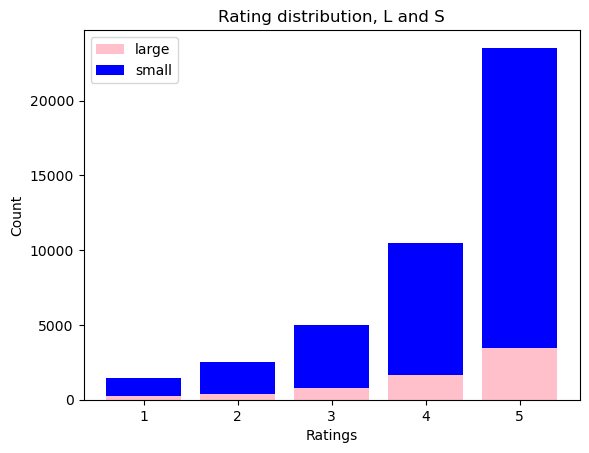

In [29]:
data_l = df[(df['user']).isin(user.loc[user['attr'] == 'L', 'id'])]['rating'].value_counts().sort_index(ascending=False)
data_s = df[(df['user']).isin(user.loc[user['attr'] == 'S', 'id'])]['rating'].value_counts().sort_index(ascending=False)


# ax = data_f.bar(title='Distribution Of {} ratings for men and women'.format(df.shape[0]))
# ax = data_m.bar(title='Distribution Of {} ratings for men and women'.format(df.shape[0]))

plt.bar(data_l.index, data_l, color='pink')
plt.bar(data_s.index, data_s, bottom=data_l, color='b')

plt.title('Rating distribution, L and S')
plt.legend(['large', 'small'])
# # plt.set_xticks([0,1,2,3,4])
plt.xlabel('Ratings')
plt.ylabel('Count')
# plt.grid(color='lightgray', which='major')
# plt.show()


In [30]:
data_l

rating
5    3461
4    1638
3     771
2     390
1     266
Name: count, dtype: int64

In [31]:
data_s

rating
5    20074
4     8826
3     4251
2     2152
1     1212
Name: count, dtype: int64

In [32]:
data_l / (data_l + data_s)

rating
5    0.147058
4    0.156537
3    0.153524
2    0.153423
1    0.179973
Name: count, dtype: float64

In [33]:
data_s / (data_l + data_s)

rating
5    0.852942
4    0.843463
3    0.846476
2    0.846577
1    0.820027
Name: count, dtype: float64

**<font color='red'>88%</font>** of the ratings belong to size small approximately. Their view probably affects the general view.

### Ratings Distribution By Item

Text(0, 0.5, 'Count')

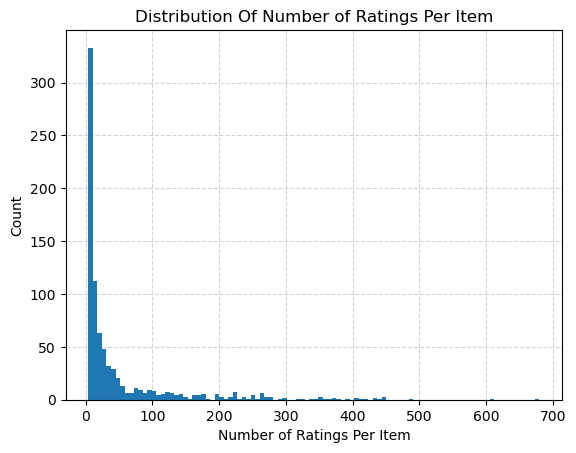

In [34]:
# Number of ratings per item
data = df.groupby('item')['rating'].count()#.clip(upper=50)

ax = data.plot.hist(title='Distribution Of Number of Ratings Per Item', bins=100)
ax.grid(True, color='lightgray', linestyle='--')
# ax.set_xticks([0,1,2,3,4])
ax.set_axisbelow(True)
ax.set_xlabel('Number of Ratings Per Item')
ax.set_ylabel('Count')


**<font color='red'>Difference: items have less ratings in average than movielens.</font>**

#### By size

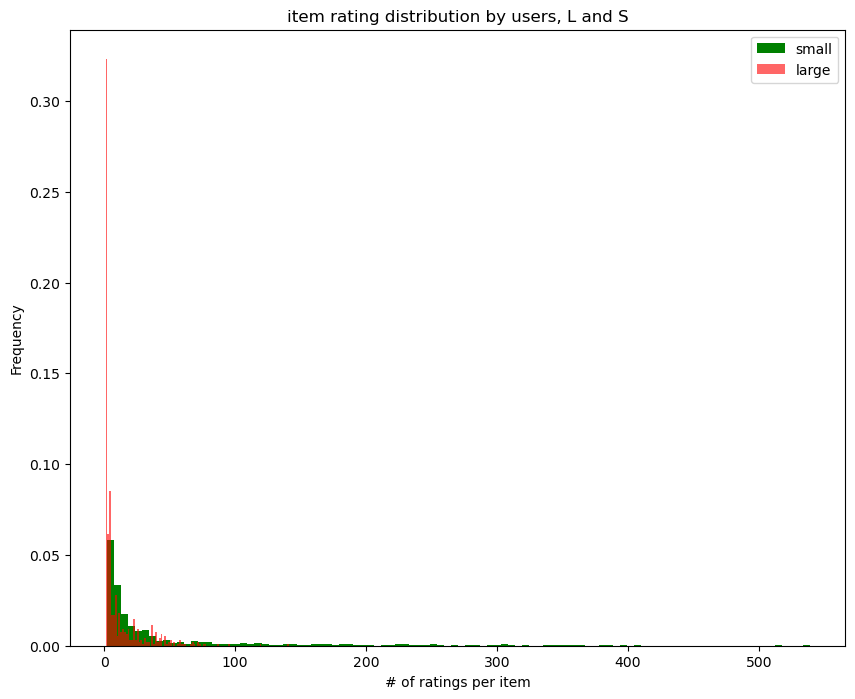

In [35]:
data_l = df[(df['user']).isin(user.loc[user['attr'] == 'L', 'id'])].groupby('item')['rating'].count()
data_s = df[(df['user']).isin(user.loc[user['attr'] == 'S', 'id'])].groupby('item')['rating'].count()


#Stack the data
plt.figure(figsize=(10,8))
# plt.hist([data_f, data_m], stacked=True, density=True)
# ax = data_m.plot.hist(bins=100, label='male', density=1, color='green')
# ax = data_f.plot.hist(bins=100, label='female', alpha=0.6,density=1, color='red')
ax = data_s.plot.hist(bins=100, label='small', density=1, color='green')
ax = data_l.plot.hist(bins=100, label='large', alpha=0.6,density=1, color='red')


ax.set_title('item rating distribution by users, L and S')
ax.set_xlabel('# of ratings per item')
ax.legend()
plt.show()


**<font color='red'>Difference: male and female users are more similar in number of ratings than movielens.</font>**

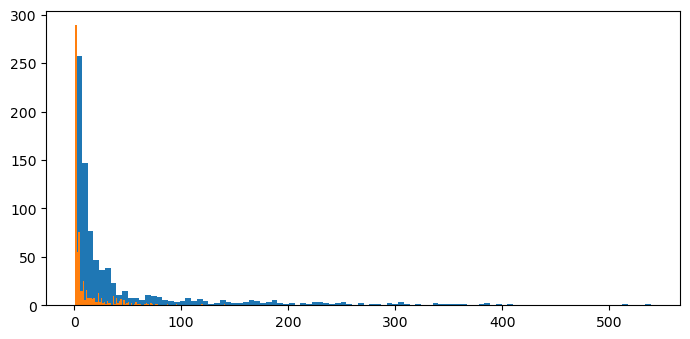

In [36]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
# a = np.random.random(100) * 0.5
# b = 1 - np.random.normal(size=100) * 0.1
bins = 100
b = np.histogram(np.hstack((data_l, data_s)), bins=bins)[1]
plt.hist(data_s, bins)
plt.hist(data_l, bins) # edgecolor='black'

plt.show()

- Size large have less ratings than small in general
- the long tail is shorter (but probably the controvertial items)
- their ratings are more focused on the popular items
- size large's ratings of more popular items are more while size small's ratings are more diverse and on more items.
    - so then shouldn't size large receive good ratings because they are close to the majority of users?

- @INSIGHT: many of the items that are removed actually were rated by size large! wth! we have many cold start users that are size large! 
- all the users have at least 20 ratings, but after the ncore, some of them are removed. in the long tail there are items that are rated by size small and large but are removed after the ncore. This could exacerbate the accuracy imbalance.
- we should try the data as is as well.
- there are some items that are only rated by size small or large! specially in the long tail.


- we have some nan values below

In [37]:
ratings_l_s = pd.DataFrame([data_l,data_s])
ratings_l_s

item,6454,7443,11960,16411,21296,22563,24853,27439,27590,28252,...,154543,154663,154668,154762,154797,154855,154913,154943,154947,155305
rating,1.0,42.0,39.0,60.0,96.0,47.0,46.0,39.0,27.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,32.0,313.0,306.0,387.0,516.0,307.0,270.0,230.0,172.0,213.0,...,15.0,4.0,9.0,5.0,27.0,8.0,10.0,12.0,6.0,4.0


In [38]:
# we have this many items, so the length is fine???
ratings_l_s.shape

(2, 825)

### Ratings Distribution By User

Text(0, 0.5, 'Count')

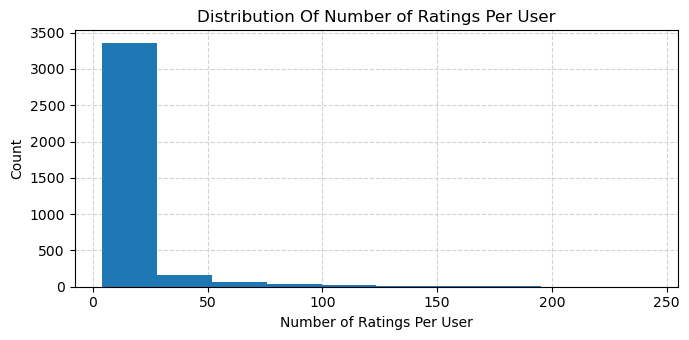

In [39]:
data = df.groupby('user')['rating'].count()#.clip(upper=50)

ax = data.plot.hist(title='Distribution Of Number of Ratings Per User')
ax.grid(True, color='lightgray', linestyle='--')
# ax.set_xticks([0,1,2,3,4])
ax.set_axisbelow(True)
ax.set_xlabel('Number of Ratings Per User')
ax.set_ylabel('Count')

**<font color='red'>Difference: users have much less ratings!!!</font>**

In [40]:
all_results = []

**Repeat every step from here 5 times and save the results in the list `all_results`.**

# RatingDataset() class

To load a dataset from a pandas dataframe, we will use the load_from_df() method The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

## Split into train and test

Note that this class is based on the data class in Surprise but it is not the same or connected to it whatsoever.

<font color='red'>Change: least_userlen_test changed from 10 to 5. Test percentage is 0.2.</font>

In [41]:
# data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

dataset = RatingDataset()
data_fn = './filtered_mc_%icore.csv'%n_core
dataset.read_from_file(data_fn, skip_lines=1, line_format='user item rating', sep=',')

print('# users', dataset.user_n)
print('# items', dataset.item_n)

# user_tests is the test_mat
train_mat, test_mat = dataset.train_test_split(test_percent=0.2, least_userlen_test=5)

# ir = the pair of (item, rating)
# ir = user_ratings[user_iid][ir_idx]

user_ratings = dataset.list_users_ratings(dataset.rating_mat)
print(dataset.rating_mat.shape)

# users 3679
# items 825

Number of users with some items in testset: 2451
Number of ratings in trainset: 36084 	 Number of ratings in testset: 6957

(3679, 825)


## Train & Test to Dataframes

### train set

In [42]:
user_ratings = dataset.list_users_ratings(train_mat)
# user_ratings[0]
# train_df = pd.DataFrame(columns = ['item','rating'])

tr_lst = []

for user_iid in range(dataset.user_n): 
    # trainset or dataset.user_n?? we keep the users the same (user-fixed) so they are equal.
    
    if user_ratings[user_iid]:
        base_rec = pd.DataFrame(user_ratings[user_iid])
        base_rec[2] = user_iid

        tr_lst.append(base_rec[[2,0,1]])
    
train_df = pd.concat(tr_lst, ignore_index=True)
train_df.columns = ['user','item','rating']


print('unique users',np.unique(train_df['user']).shape)
print('unique items',np.unique(train_df['item']).shape)
print(train_df.shape)

train_df.head()

unique users (3679,)
unique items (825,)
(36084, 3)


,user,item,rating
0,0,74,1.0
1,0,82,4.0
2,0,188,5.0
3,0,425,5.0
4,0,647,5.0


### test set

In [43]:
# test set to a dataframe
test_lst = []

for uiid in test_mat.keys():
    base_rec = pd.DataFrame(test_mat[uiid])
    base_rec[2] = uiid
    test_lst.append(base_rec[[2,0,1]])


test_df = pd.concat(test_lst, ignore_index=True)
test_df.columns = ['user','item','rating']

print('users',np.unique(test_df['user']).shape)
print('items',np.unique(test_df['item']).shape)
print(test_df.shape)

test_df.head()

users (2451,)
items (701,)
(6957, 3)


,user,item,rating
0,0,497,5.0
1,1,193,4.0
2,1,521,5.0
3,1,575,5.0
4,1,598,1.0


In [44]:
test_df.shape[0] + train_df.shape[0]

43041

## rating distribution of  training set and test set

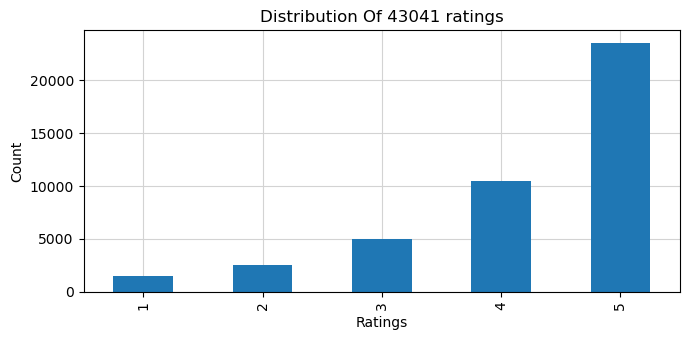

In [45]:
# all_d = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates(keep=False)
# print(all_d.shape)
# df.equals(all_d)b
data = df['rating'].value_counts().sort_index(ascending=True)

ax = data.plot(kind='bar', title='Distribution Of {} ratings'.format(df.shape[0]))
ax.grid(True, color='lightgray', linestyle='-')
ax.set_xticks([0,1,2,3,4])
ax.set_xlabel('Ratings')
ax.set_ylabel('Count')
ax.set_axisbelow(True)

Index([5.0, 4.0, 3.0, 2.0, 1.0], dtype='float64', name='rating')
Index([5.0, 4.0, 3.0, 2.0, 1.0], dtype='float64', name='rating')


Text(0, 0.5, 'Count')

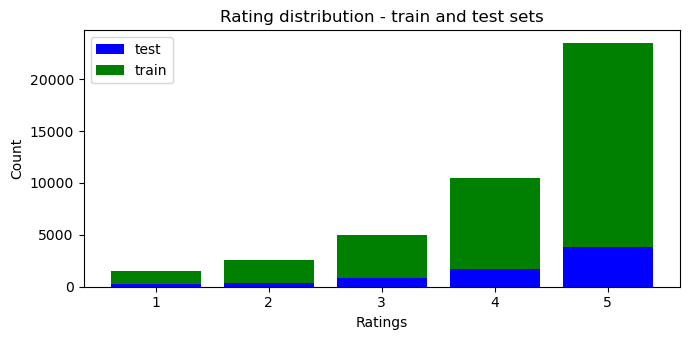

In [46]:
data_tr = train_df['rating'].value_counts().sort_index(ascending=False)
data_ts = test_df['rating'].value_counts().sort_index(ascending=False)

print(data_tr.index)
print(data_ts.index)

plt.bar(data_ts.index, data_ts, color='b')
plt.bar(data_tr.index, data_tr, bottom=data_ts, color='g')

plt.title('Rating distribution - train and test sets')
plt.legend(['test', 'train'])
# plt.grid(True, color='lightgray', linestyle='-')
# plt.set_xticks([0,1,2,3,4])
plt.xlabel('Ratings')
plt.ylabel('Count')

## Pro and Unpro - id to iid (ID to Index)

In [47]:
user.dtypes
# turn user id into string so you can retrieve int iid

id        object
attr      object
is_pro     int64
dtype: object

In [48]:
'pro & unpro data structures'

# global pro_users_id
# global unpro_users_id

# pro_users_id = []
# unpro_users_id = []

global pro_users_index
global unpro_users_index

pro_users_index = []
unpro_users_index = []


# initializing a column
# this is inner id or index
user['iid'] = 0

for i, row in user[['id', 'is_pro']].iterrows():
    
    # user id to inner_id (index)
    u_index = dataset.user_to_iid[str(row['id'])]
    # print(row['id'], u_index, dataset.user_to_ID[u_index])
    
    # just add the inner id (index) to the user dataframe
    user.loc[user['id']==row['id'], 'iid'] = u_index
    
    
    if row['is_pro'] == 1:
        # pro_users_id.append(row['id'])
        pro_users_index.append(u_index)
    
    else:
        # unpro_users_id.append(row['id'])
        unpro_users_index.append(u_index)  


print('protected users', len(pro_users_index))
print('unprotected users', len(unpro_users_index))
print()

user.head(5)


protected users 943
unprotected users 2736



,id,attr,is_pro,iid
0,Alex,S,0,3620
2,Robyn,S,0,2159
4,tasha,S,0,2953
6,Kim,S,0,2062
8,Elissa,S,0,857


### iid 2 gender & reverse

In [49]:
# dictionary of iid and gender

iid_to_attr = dict(zip(user.iid, user.attr))
# gender_to_iid = dict(zip(user.gender, user.iid))

id_to_attr = dict(zip(user.id, user.attr))
# gender_to_id = dict(zip(user.gender, user.id))


### Deepcopy train & test w gender info

In [50]:
#copy training set
# it won't affect train_df, only the copy has an extra column
train_df_cp = train_df.copy(deep=True)
test_df_cp = test_df.copy(deep=True)


train_df_cp['attr'] = train_df['user'].map(iid_to_attr)
test_df_cp['attr'] = test_df['user'].map(iid_to_attr)

### rating , gender, count (tr, ts)

In [51]:
s_l_cnt = []
for a, b in train_df_cp.groupby(['rating', 'attr']):
    s_l_cnt.append((float(a[0]), a[1], int(len(b))))
    print(a, len(b))
    
# print(m_f_cnt, '\n') 
print()

s_l_cnt_ts = []
for a, b in test_df_cp.groupby(['rating', 'attr']):
    s_l_cnt_ts.append((float(a[0]), a[1], int(len(b))))
    print(a, len(b))
    
# print(m_f_cnt_ts)

(1.0, 'L') 232
(1.0, 'S') 1005
(2.0, 'L') 337
(2.0, 'S') 1817
(3.0, 'L') 671
(3.0, 'S') 3522
(4.0, 'L') 1405
(4.0, 'S') 7391
(5.0, 'L') 2989
(5.0, 'S') 16715

(1.0, 'L') 34
(1.0, 'S') 207
(2.0, 'L') 53
(2.0, 'S') 335
(3.0, 'L') 100
(3.0, 'S') 729
(4.0, 'L') 233
(4.0, 'S') 1435
(5.0, 'L') 472
(5.0, 'S') 3359


In [52]:
np.array(s_l_cnt)[::2, :]

array([['1.0', 'L', '232'],
       ['2.0', 'L', '337'],
       ['3.0', 'L', '671'],
       ['4.0', 'L', '1405'],
       ['5.0', 'L', '2989']], dtype='<U32')

In [53]:
np.array(s_l_cnt)[::-2, :][::-1]

array([['1.0', 'S', '1005'],
       ['2.0', 'S', '1817'],
       ['3.0', 'S', '3522'],
       ['4.0', 'S', '7391'],
       ['5.0', 'S', '16715']], dtype='<U32')

### plot ratings sep by size and tr/ts

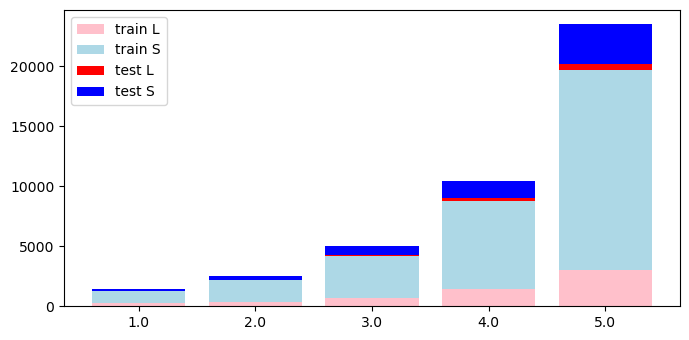

In [54]:


# large size train
l_tr = np.array(s_l_cnt)[::2, :]
plt.bar(l_tr[:, 0], l_tr[:, 2].astype(int), color='pink', label='train L')

s_tr = np.array(s_l_cnt)[::-2, :][::-1]
plt.bar(s_tr[:, 0], s_tr[:, 2].astype(int),
        bottom = l_tr[:, 2].astype(int), color='lightblue', label='train S')



# test set
l_ts = np.array(s_l_cnt_ts)[::2, :]
plt.bar(l_ts[:, 0], l_ts[:, 2].astype(int),
        bottom=l_tr[:, 2].astype(int) + s_tr[:, 2].astype(int), 
        color='red', label='test L')

s_ts = np.array(s_l_cnt_ts)[::-2, :][::-1]
plt.bar(s_ts[:, 0], s_ts[:, 2].astype(int),
        bottom = l_tr[:, 2].astype(int) + s_tr[:, 2].astype(int) + l_ts[:, 2].astype(int),
        color='blue', label='test S')


plt.legend()

### ratio of large size to small size in train and text

In [55]:

print('training set')
# train l
p_l_r = l_tr[:, 2].astype(int) / (l_tr[:, 2].astype(int) + s_tr[:, 2].astype(int))
p_s_r = s_tr[:, 2].astype(int) / (l_tr[:, 2].astype(int) + s_tr[:, 2].astype(int))

print(('prob Large given rating \t one {0} \n\t\t\t\t two {1} \n\t\t\t\t three {2} ' +
      '\n\t\t\t\t four {3} \n\t\t\t\t five {4}').format(*p_l_r))
print()
print(('prob Small given rating \t one {0} \n\t\t\t\t two {1} \n\t\t\t\t three {2} ' + 
      '\n\t\t\t\t four {3} \n\t\t\t\t five {4}').format(*p_s_r))
# print(p_f_r + p_m_r)



print('\n\ntest set')
p_l_r_ts = l_ts[:, 2].astype(int) / (l_ts[:, 2].astype(int) + s_ts[:, 2].astype(int))
p_s_r_ts = s_ts[:, 2].astype(int) / (l_ts[:, 2].astype(int) + s_ts[:, 2].astype(int))

print(('prob Large given rating \t one {0} \n\t\t\t\t two {1} \n\t\t\t\t three {2} ' + 
      '\n\t\t\t\t four {3} \n\t\t\t\t five {4}').format(*p_l_r_ts))
print()
print(('prob Small given rating \t one {0} \n\t\t\t\t two {1} \n\t\t\t\t three {2} ' + 
      '\n\t\t\t\t four {3} \n\t\t\t\t five {4}').format(*p_s_r_ts))



training set
prob Large given rating 	 one 0.18755052546483428 
				 two 0.1564531104921077 
				 three 0.16002861912711663 
				 four 0.15973169622555708 
				 five 0.1516950872919204

prob Small given rating 	 one 0.8124494745351657 
				 two 0.8435468895078923 
				 three 0.8399713808728834 
				 four 0.840268303774443 
				 five 0.8483049127080796


test set
prob Large given rating 	 one 0.14107883817427386 
				 two 0.13659793814432988 
				 three 0.12062726176115803 
				 four 0.1396882494004796 
				 five 0.1232054293918037

prob Small given rating 	 one 0.8589211618257261 
				 two 0.8634020618556701 
				 three 0.879372738238842 
				 four 0.8603117505995204 
				 five 0.8767945706081963


The ratio oof Small and Large in train and test is similar. The probability of being a Large given you have rated an item one is <font color='red'>13%</font> which is <font color='red'>slightly</font> higher than other ratings.

# Q: What is this? for the ratios of ratings?

### rating cnt, avg, median of ratings for m and f (TRAINING SET)

- if the distribution is symmetrical mean and meadian will be the same
- if the dist is skewed to the right (positively skewed, or the right side is thinner), it means that smaller numbers are more, then the median becomes one fo those small numbers. Since mean changes when when a few big numbers are added, mean becomes bigger. So median will be smaller than the mean.
- if it is skewed to the left or negatively skewed, the big numbers are more and so the median is a big number. the mean changes and becomes smaller as small numbers are added to it, so the median becomes bigger than the mean.
- so if median > mean, the dist is left skewed, so higher ratings are more common.
- if the median < mean, the dist is right skewed, so lower ratings are more common.
- is the difference statistically significant or not?

#### train set

In [56]:
# training set
# this is calcualted based on the training set only


# a dictionary of the number of ratings an item has received from Small and Large separately
# a dictionary of median and avg of rating of Small & Large on an item
item_l_s_cnt_dic = {} 


# starting from here, in case an item is not rated by one size group
for item in list(np.unique(train_df_cp.item)):
    item_l_s_cnt_dic[item] = {'L_c':0., 'S_c':0., 'L_med':0., 'L_avg':0.,'S_med':0., 'S_avg':0.} 

    
for a, b in train_df_cp.groupby(['item', 'attr']):
    
    # how many ratings, rating count
    item_l_s_cnt_dic[a[0]][a[1]+'_c'] += len(b)
    
    # median and mean
    item_l_s_cnt_dic[a[0]][a[1]+'_med'] += b['rating'].median()
    item_l_s_cnt_dic[a[0]][a[1]+'_avg'] += b['rating'].mean()

    
# print(item_f_m_cnt_dict)

item_l_s_cnt = pd.DataFrame.from_dict(item_l_s_cnt_dic, orient='index').reset_index()
item_l_s_cnt.rename(columns={'index':'item_iid'}, inplace=True)

print()
print(item_l_s_cnt.shape)
item_l_s_cnt.head()



(825, 7)


,item_iid,L_c,S_c,L_med,L_avg,S_med,S_avg
0,0,1.0,9.0,4.0,4.000000,4.0,3.555556
1,1,1.0,5.0,5.0,5.000000,5.0,4.600000
2,2,48.0,236.0,5.0,4.583333,5.0,4.555085
3,3,45.0,155.0,5.0,4.622222,5.0,4.477419
4,4,1.0,6.0,5.0,5.000000,4.5,4.166667


#### test set

In [57]:
# a dictionary of the number of ratings an item has received from Small and Large separately
# a dictionary of median and avg of rating of Small & Large on an item
item_l_s_cnt_dic_ts = {} 


# starting from here, in case an item is not rated by one size group
for item in list(np.unique(test_df_cp.item)):
    item_l_s_cnt_dic_ts[item] = {'L_c':0., 'S_c':0., 'L_med':0., 'L_avg':0.,'S_med':0., 'S_avg':0.} 

    
for a, b in test_df_cp.groupby(['item', 'attr']):
    
    # how many ratings, rating count
    item_l_s_cnt_dic_ts[a[0]][a[1]+'_c'] += len(b)
    
    # median and mean
    item_l_s_cnt_dic_ts[a[0]][a[1]+'_med'] += b['rating'].median()
    item_l_s_cnt_dic_ts[a[0]][a[1]+'_avg'] += b['rating'].mean()

    
# print(item_f_m_cnt_dict)

item_l_s_cnt_ts = pd.DataFrame.from_dict(item_l_s_cnt_dic_ts, orient='index').reset_index()
item_l_s_cnt_ts.rename(columns={'index':'item_iid'}, inplace=True)

print()
print(item_l_s_cnt_ts.shape)
item_l_s_cnt_ts.head()



(701, 7)


,item_iid,L_c,S_c,L_med,L_avg,S_med,S_avg
0,0,1.0,3.0,2.0,2.000000,4.0,3.666667
1,1,0.0,2.0,0.0,0.000000,4.5,4.500000
2,2,6.0,47.0,4.5,4.000000,5.0,4.553191
3,3,6.0,22.0,5.0,4.333333,5.0,4.636364
4,4,0.0,1.0,0.0,0.000000,5.0,5.000000


- NOTE: if there zeros it only means that there were not any ratings! there are no ratings of zero!
- keep that in mind while doing the comparisions!

# Consumer-Side Fairness Metrics

note that iid here means item-id not inner-id

- 0: uid,    
- 1: iid,    
- 2:r_ui,    
- 3: est


- g: disadvantaged,    
- -g: advantaged

## Common Functions 

### Average Score

In [58]:

def avg_score(df_i, itemid, users, est=False): 
    if est:
        pred_type = 'est'
    else:
        pred_type = 'r_ui'
        
    f_df = df_i.loc[(df_i['uid']).isin(users), pred_type]
    
    return f_df.mean()

### Separate Preds for Pro & Unpro

In [59]:
def seperate_preds(preds):
    
    pro_preds = []
    unpro_preds = []

    for row in preds:
        # check here: pro_users_index
        if row.uid in pro_users_index:
            pro_preds.append(row)
        else:
            unpro_preds.append(row)
            
    return pro_preds, unpro_preds

### Pro & Upro Counts

In [60]:
#  not sure if I use this function at all!
def pro_unpro_count(preds):
    
    pros= []
    unpros =[]
    
    for row in preds:
        if row.uid in pro_users_index:
            pros.append(row.uid)
        else:
            unpros.append(row.uid)
            
    return np.unique(pros), np.unique(unpros)

### Item Eligibility (for c-fairness metrics)

- ISSUE: if an item is not rated by a group, the average rating of that group will be NaN as well as the final output.

To avoid this issue, we calculate the consumer-side fairness metrics over items that were rated by both groups (Pro & Unpro).

- NOTE: Therefore all the metrics below are calcualted over the common items.

In [61]:
def is_i_eligible(item_df):
    
    # if there is only one rating, return False
    cond_a = len(item_df) >= 2
    
    #check here: pro_users_index, is item_df['uid] == item_df['uid'].tolist() ?
    if cond_a:
        # if this item has ratings from both the protected and unprotected user groups
        cond_b = np.any(np.any((item_df['uid']).isin(pro_users_index)) and
                       np.any((item_df['uid']).isin(unpro_users_index)))
        return cond_b
    
    return False

## Value Fairness

In [62]:
def value_unfairness(p_df):
    
    '''
    value unfairness, measures inconsistency in signed estimation error across the user types
    
    Value unfairness occurs when one class of user is consistently given higher or lower predictions
    than their true preferences. If the errors in prediction are evenly balanced between overestimation
    and underestimation or if both classes of users have the same direction and magnitude of error, the
    value unfairness becomes small. Value unfairness becomes large when predictions for one class
    are consistently overestimated and predictions for the other class are consistently underestimated.
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid']):

        item_df = p_df[p_df['iid'] == itemid]
        
        # skip the item that doesn't have more than 2 ratings or ratings from both pro & unpro
        if not is_i_eligible(item_df):
            continue

        e_g_y = avg_score(item_df, itemid, pro_users_index, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users_index, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users_index, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users_index, est=False)
        
        sum_err += abs((e_g_y - e_g_r) - (e_ng_y - e_ng_r))
    
    # if non of the items had any ratings. it's a rare condition.
    if sum_err == 0:
        return 'ERROR: non of the items had any ratings.'
        
    return sum_err/np.unique(p_df['iid']).size

In [63]:
print('# of ratings', len(df['rating'].tolist()))

# of ratings 43041


In [64]:
# value_unfairness(pd.DataFrame(predictions_al_p))

## Nonparity

In [65]:
def non_parity(p_df):
    
    '''
    nonparity measure based on the regularization term introduced by Kamishima et al. 
    can be computed as the absolute difference between the overall average ratings of disadvantaged users 
    and those of advantaged users.
    '''
    e_g_y = p_df.loc[(p_df['uid']).isin(pro_users_index), 'est'].mean()
    e_ng_y = p_df.loc[(p_df['uid']).isin(unpro_users_index), 'est'].mean()
    
    return abs(e_g_y - e_ng_y)

# Active Learning

### number of iterations/epocs

In [66]:
train_df.shape

(36084, 3)

### item_ratings

-  a dictionary of item iid and the (user_iid, rating)s

In [67]:
# item ratings
# a dictionary of item iid and the (user_iid, rating)

# item_ratings = dataset.list_items_ratings(dataset.rating_mat) 
item_ratings = dataset.list_items_ratings(train_mat)

# print(len(item_ratings[3]))
print(len(item_ratings))


825


In [68]:
dataset.item_n

825

In [69]:
range(dataset.item_n)

range(0, 825)

## Attention-based Popularity

Attention-based. This group of strategies focus on selecting the
items that have received the highest “attention” among the
users. Such items are likely to be known by the users, and
therefore they can be rated by them. Hence, these strategies
usually add a lot of ratings. These strategies are
simple and easy to implement and they were introduced
in the initial attempts to solve the cold start problem in
collaborative filtering. They are considered as baseline
strategies.

Popularity: selects the most popular items, i.e., those
with the highest number of ratings. It is very likely that the
users are able to rate these items and consequently the
size of the rating dataset can be increased. However,
popular items are typically widely liked by the users.
Therefore, their ratings usually bring little information
to the system. Moreover, this strategy may cause the
*prefix bias*, i.e., the system trained with ratings for
popular items tend also to recommend these popular
items, making them even more popular.

### Order the items in the training set based on their popularity

In [70]:
# based on the training set
item_pop_df = pd.DataFrame(train_df.groupby('item')['rating'].count()).sort_values(by='rating', 
                                                                                    ascending=False).reset_index()

item_pop_df.columns = ['item_iid','popularity']

print (item_pop_df.shape)

item_pop_df.head()

(825, 2)


,item_iid,popularity
0,599,582
1,82,514
2,85,405
3,678,383
4,771,379


### Sorting the dataset based on the item popularity

In [71]:
# computing the item counts
item_pop_df = []
# pd.DataFrame(columns=['item_iid','popularity'])

# question: apparently we are item-fixed and user-fixed. the number of items is the same in train and test sets!
# be careful about this.
for item_iid in range(dataset.item_n):
    item_pop_df.append((item_iid,len(item_ratings[item_iid]))) 
    
item_pop_df = pd.DataFrame(item_pop_df, columns=['item_iid','popularity'])
item_pop_df.sort_values(by='popularity', ascending=False, ignore_index=True, inplace=True)

print(item_pop_df.head())
# to see if this was equal to the previous way of creating this dataframe
# (np.array(item_pop_df) == np.array(item_pop_df)).all()

print(item_pop_df.shape)

   item_iid  popularity
0       599         582
1        82         514
2        85         405
3       678         383
4       771         379
(825, 2)


## Attention-based Square(Popularity) * Variance

### Normalized Popularity 

In [72]:
# normalize popularity scores

item_pop_df['norm_pop'] = 0

min_pop = item_pop_df['popularity'].tolist()[-1]
max_pop = item_pop_df['popularity'].tolist()[0]

for inx, row in item_pop_df.iterrows():
    item_pop_df.loc[inx, 'norm_pop'] = ((row['popularity'] - min_pop) / (max_pop - min_pop))
    
item_pop_df.head()


,item_iid,popularity,norm_pop
0,599,582,1.000000
1,82,514,0.882759
2,85,405,0.694828
3,678,383,0.656897
4,771,379,0.650000


In [73]:
print (item_pop_df.shape)

(825, 3)


### Item Sqrt(norm pop) * Variance

- note that the calcualtion of variance in numpy and dataframe isn't the same

- Note: sometimes some of these items end up with no ratings and this shows an error!

In [74]:
# computing the item variance
item_var_df = []
#

# question: apparently we are item-fixed and user-fixed. the number of items is the same in train and test sets!
# be careful about this.
for item_iid in range(dataset.item_n):
    item_var_df.append((item_iid, np.array(item_ratings[item_iid])[:,1].var(),
                        (np.array(item_ratings[item_iid])[:,1].var()) * np.sqrt(item_pop_df.loc[item_pop_df['item_iid'] == item_iid,'norm_pop'].values[0])))


item_var_df = pd.DataFrame(item_var_df, columns=['item_iid','variance', 'sqrt pop x var'])
# sorting based on sqrt(norm popularity) * variance
item_popvar_df = item_var_df.sort_values(by='sqrt pop x var', ascending=False, ignore_index=True)

print(item_popvar_df.shape)
item_popvar_df.head()


(825, 3)


,item_iid,variance,sqrt pop x var
0,332,1.510698,1.204972
1,447,1.448920,1.125549
2,82,1.135100,1.066486
3,10,1.253854,0.997392
4,585,1.657029,0.965715


## Uncertainty Reduction Based on Variance

In [75]:
# sorting based on variance
item_uc_var_df = item_var_df.sort_values(by='variance', ascending=False, ignore_index=True)

print(item_uc_var_df.shape)
item_uc_var_df.head()



(825, 3)


,item_iid,variance,sqrt pop x var
0,787,3.555556,0.147636
1,279,3.187500,0.187176
2,40,3.000000,0.176166
3,197,2.979592,0.276648
4,517,2.816327,0.261489


### item table

In [76]:
item_l_s_cnt['pop'] = 0
item_l_s_cnt['normpop'] = 0
item_l_s_cnt['var'] = 0
item_l_s_cnt['sqrt normpopvar'] = 0


for itemid in item_l_s_cnt['item_iid'].tolist():
    
    
    item_l_s_cnt.loc[item_l_s_cnt['item_iid'] == itemid,
                     'pop'] = item_pop_df.loc[item_pop_df['item_iid'] == itemid,
                                              'popularity'].values[0]
    
    item_l_s_cnt.loc[item_l_s_cnt['item_iid'] == itemid,
                     'npop'] = item_pop_df.loc[item_pop_df['item_iid'] == itemid,
                                              'norm_pop'].values[0]
    
    item_l_s_cnt.loc[item_l_s_cnt['item_iid'] == itemid,
                     'var'] = item_popvar_df.loc[item_popvar_df['item_iid'] == itemid,
                                              'variance'].values[0]
    
    item_l_s_cnt.loc[item_l_s_cnt['item_iid'] == itemid,
                 'sqrt npopvar'] = item_popvar_df.loc[item_popvar_df['item_iid'] == itemid,
                                          'sqrt pop x var'].values[0]
    

item_l_s_cnt.head()

# item_f_m_cnt[item_f_m_cnt['item_iid'] == 1155]

# can sort it like this
# item_f_m_cnt.sort_values(by='pop', ascending=False)

,item_iid,L_c,S_c,L_med,L_avg,S_med,S_avg,pop,normpop,var,sqrt normpopvar,npop,sqrt npopvar
0,0,1.0,9.0,4.0,4.000000,4.0,3.555556,10,0,2.040000,0,0.013793,0.239586
1,1,1.0,5.0,5.0,5.000000,5.0,4.600000,6,0,0.555556,0,0.006897,0.046136
2,2,48.0,236.0,5.0,4.583333,5.0,4.555085,284,0,0.661910,0,0.486207,0.461540
3,3,45.0,155.0,5.0,4.622222,5.0,4.477419,200,0,0.649900,0,0.341379,0.379721
4,4,1.0,6.0,5.0,5.000000,4.5,4.166667,7,0,1.061224,0,0.008621,0.098532


## Surprise

In [77]:
# from surprise import BaselineOnly
from surprise import NMF, SVD, NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

# from surprise.model_selection import KFold

In [78]:
reader = Reader(rating_scale=(1, 5))

# algo = SVD()

whole_df = pd.concat([train_df, test_df]).drop_duplicates(ignore_index=True)
whole_df.shape

(43041, 3)

### Grid Search & Algo Tuning

In [79]:
n_core

3

### Oracle - cheat - all data

In [80]:
tstart = datetime.now()

# SVD(n_epochs=200, n_factors=200,lr_all=0.005, reg_all=0.01, verbose=False, random_state=41023)
oracle_ = SVD(n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=41023)

trainset_all_ = Dataset.load_from_df(whole_df[['user', 'item', 'rating']],reader).build_full_trainset()
testset_all_ = Dataset.load_from_df(test_df[['user', 'item', 'rating']],reader).build_full_trainset().build_testset()

oracle_.fit(trainset_all_)
fin_preds = oracle_.test(testset_all_)
fin_acc_o_ = accuracy.rmse(fin_preds, verbose=False)

print(fin_acc_o_)

tend = datetime.now()  
print("\n Active learning in ms : \n")
print(tend-tstart)

0.0008781837145152919

 Active learning in ms : 

0:00:03.462343


### Accuracy on only training data

In [81]:
tstart = datetime.now()

oracle = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
#oracle = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
#oracle = SVD(n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=41023)
    #n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=41023)

trainset_all = Dataset.load_from_df(train_df[['user', 'item', 'rating']],
                                    reader).build_full_trainset()
testset_all = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()

oracle.fit(trainset_all)
fin_preds = oracle.test(testset_all)
fin_acc_o = accuracy.rmse(fin_preds, verbose=False)

print(fin_acc_o)

tend = datetime.now() 
print("\n Active learning in ms : \n")
print(tend-tstart)

1.0728445414479544

 Active learning in ms : 

0:00:00.729812


In [82]:
print(train_df.shape)
print(test_df.shape)

(36084, 3)
(6957, 3)


In [83]:
print(trainset_all.n_ratings)
print(len(testset_all))

36084
6957


## Greedy Extend

Code an Oracle in an expensive way and a cheap way

### Training without a specific item function

In [84]:
def retrain_without(item_iid, tr, tes, rec_mod):
        
    # should I remove from both train and test?
    tr_filt = tr[tr['item'] != item_iid]

#     tes_filt = tes[tes['item'] != item_iid]
    tes_filt = tes
    
    tr_temp = Dataset.load_from_df(tr_filt[['user', 'item', 'rating']],
                                   reader).build_full_trainset()
    tes_temp = Dataset.load_from_df(tes_filt[['user', 'item', 'rating']],
                                    reader).build_full_trainset().build_testset()

    rec_mod.fit(tr_temp)
    
    temp_preds = rec_mod.test(tes_temp)
    
    temp_acc = accuracy.rmse(temp_preds, verbose=False)

    return([item_iid, temp_acc])


In [85]:
np.unique(train_df['item']).size

825

In [86]:
dataset.item_n

825

In [87]:
np.unique(test_df['item']).size

701

### Run: Parallel computations

- Both the training set and the test set have both items and users. we remove the items from the trianing set and calcualte the rmse on the test set. of course adding back the item will decrease RMSE! we have it in the test set! But how about how the addition ofo an item in general changes the model? In that case, we need to remove the whole item from both training set and the test set! Then we see if adding that item back will make the model better and reduces the RMSE.

In [88]:
# set the SVD model with the best parameters you could get
# algo = SVD(n_epochs = 100, n_factors = 50, lr_all=0.005, reg_all=0.05, verbose = False, random_state=41023)
algo = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
# algo = SVD(n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=41023)

In [89]:
# conda install multiprocess
# We are calculating the rmse for all of the training set.
# Then we remove every item one by one and see which one improves the accuracy after it's added.

start = timeit.default_timer()
import multiprocess as mp


def comp_tr(iid):
    # if the item id exists in the ncore training data (test too?)
    # if train_df[train_df['item']==item_iid].shape != 0:
    return (retrain_without(iid, train_df, test_df, algo))


if __name__ == "__main__":
    
    pool = mp.Pool(processes=15)
    results = pool.map(comp_tr, list(range(dataset.item_n)))
    
    # note that these two are the same, so we don't have to worry about the inner ides(how about the DATASET CLASS)
    # list(np.unique(train_df['item'])) == list(range(dataset.item_n))
    # Look here, you might want to run this for the WHOLE DATA!
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))
    
    

Process Time: 75.08 secs


- the number of items in the trian and test might not be the same!

In [90]:
len(list(range(dataset.item_n)))

825

In [91]:
np.unique(train_df['item']).shape

(825,)

In [92]:
np.unique(test_df['item']).shape

(701,)

### Results (item iid, rmse_without)

-  Pick the ones that reduce the error

In [93]:
fin_acc_o

1.0728445414479544

In [94]:
# set this parameter

# which one is the final RMSE? th eone with all the data or only all the training
fin_acc = fin_acc_o
fin_acc

1.0728445414479544

In [95]:
# new results

result_df_ge = pd.DataFrame(results, columns=['item_iid','rmse without'])
# print(result_df_ge_2.head(5), '\n')

print('rmse all', fin_acc, '\n')

result_df_ge['added rmse wo'] = fin_acc - result_df_ge['rmse without']
print(result_df_ge.head(), '\n')

# order items in terms of least addition to the rmse
result_df_sorted_ge = result_df_ge.sort_values(by='added rmse wo', ascending=True)
print(result_df_sorted_ge.head())

# we are calculating the added RMSE, therefore *negative values* are desirable!
# negative values: good values: if rmse without the item is higher than when we have it in the pool.
    # It means that item is helping decrease the RMSE which is good!
# positive values: if rmse without that item is lower than after adding it, the result is positive.
    # we don't want those items then! They increase rmse which is undesirable!
    

rmse all 1.0728445414479544 

   item_iid  rmse without  added rmse wo
0         0      1.072866      -0.000022
1         1      1.072168       0.000676
2         2      1.073820      -0.000975
3         3      1.074171      -0.001327
4         4      1.075620      -0.002776 

     item_iid  rmse without  added rmse wo
332       332      1.076291      -0.003446
809       809      1.076225      -0.003380
530       530      1.076024      -0.003179
44         44      1.075969      -0.003124
326       326      1.075946      -0.003101


# Experiments: n item(query) at a time evaluation

NOTE: we choose one or 10 item at a time and the we add all the ratings of all the users who have rated on them

In [96]:
np.unique(train_df['item']).shape[0]

825

## Known = 0.1 set for all the algos

**<font color='red'>Difference: known changed from 0.02 to 0.1 to make sure there are initial ratings.</font>**

In [97]:

def rating_dic_to_df(rating_dic):
    lst = []

    for user_iid in range(dataset.user_n): 
    
        if rating_dic[user_iid]:
            res = pd.DataFrame(rating_dic[user_iid])
            res[2] = user_iid

            lst.append(res[[2,0,1]])
    

    df = pd.concat(lst, ignore_index=True)
    df.columns = ['user','item','rating']
    return df


#-------------------------------------------------------------

# the lower bound
# initial_n = int(round((0.02 * train_df.shape[0])/dataset.user_n))
# initial_n = int(round((0.1 * train_df.shape[0])/dataset.user_n))
initial_n = 2
print('initial ratings', initial_n)


candidate_user_ratings = dataset.list_users_ratings(train_mat)
initial_user_ratings = {}


for user_iid in range(dataset.user_n):
    
    initial_user_ratings[user_iid] = []
    len_u = len(candidate_user_ratings[user_iid])
    
    if len_u >= initial_n:
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        selected_u = selected_u[:initial_n][:]

        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)
    
    else: # number of ratings less than required initial number
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        
        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)
            
            
# initial dataset turned into a dataframe
initial_train_df = rating_dic_to_df(initial_user_ratings)

print(initial_train_df.shape)
print('# users: ', np.unique(initial_train_df['user']).shape)
print('# items: ', np.unique(initial_train_df['item']).shape)
print('# users in the training set', np.unique(train_df['user']).shape)
# now the number of users in the training, test and the initial data are the same!
print('# of ratings', train_df.shape)


initial ratings 2
(7358, 3)
# users:  (3679,)
# items:  (661,)
# users in the training set (3679,)
# of ratings (36084, 3)


In [98]:
known_df = initial_train_df

In [99]:
known_df.shape

(7358, 3)

## Running all Strategies

In [100]:
range(dataset.item_n)

range(0, 825)

In [101]:
train_df.shape

(36084, 3)

# ActiveLearningProcess

**<font color='red'>Size of item window is still 10.</font>**

In [102]:
#---------------------------------------------
from tqdm import tqdm


def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
    pro_c = []
    unpro_c = []
    
    rmse = []
    rmse_pro = []
    rmse_unpro = []
    
#     vu = []
    
    tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
    # number of items
    n_itm = np.unique(train_df['item']).shape[0]
    i_indx = 0

    pbar = tqdm(desc='while loop', total=n_itm+1)
    while i_indx < n_itm:

        # if i_indx%100. == 0.:
        #     print('sample %i-th item...' %i_indx)
    

        if i_indx != 0:
            # choosing the next item to sample
            chosen_is = srt_it[i_indx:i_indx+win]

            # sample based on item popularity but without replacement.
            # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
            tr_iter = pd.concat([tr_iter, 
                                  tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()

        else:
            tr_iter = knw_df


        # turn the data into a Surprise readbale file
        trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


        # fitting to the model
        algo.fit(trainset_act)
        preds = algo.test(tes)

        # evaluating the outcome
        rmse.append(accuracy.rmse(preds, verbose=False))
        # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


        # pro & unpro RMSE
        pro_, unpro_ = seperate_preds(preds)    
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#         # value fairness
#         vu.append(value_unfairness(pd.DataFrame(preds)))


        # pro/unpro count
        pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
        unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])

        
        #----------------------------------next iteration---------------------------------
        i_indx += win
        pbar.update(1)
       
    
    pbar.close()  
    return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    


################## main #######################


if __name__ == "__main__":

    def comp_paral (akey):
        # strtgs[akey] is the sorted list of items based on a strategy
        return(akey, ac_proc(train_df, known_df, testset, w, strtgs[akey], svd_sup))
        # (tr_df, knw_df, tes, win, srt_it, algo)
     
    start = timeit.default_timer()
    import multiprocess as mp


    #------------------------item lists (act sorted & rand shuffled)---------------------
    # unique sorted items
    # if you use set() or np.unique(), they will disorder the list!
    sorted_i_pop = item_pop_df['item_iid'].tolist()

    # suffled list of items
    shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

    # uncertainty - variance
    sorted_i_v = item_uc_var_df['item_iid'].tolist()

    # items order by their Sqrt(norm pop) * Var
    sorted_i_spv = item_popvar_df['item_iid'].tolist()

    # sorted based on their contribution to RMSE
    sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

    strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
              'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}
    

    
    #------------------------ test set & algo & window ---------------------
    
    # the known set, a part of the training set
    # known_n = 0.1
    # known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
    known_df = initial_train_df
    
    
    # build the test set
    testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()
    
    
    svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
#     algo = SVD()

    # w = 10   # window of w items    
    w = 10

    
    #------------------------ function ---------------------
    pool = mp.Pool(processes=5)
    results = pool.map(comp_paral, list(strtgs.keys()))
#     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))



while loop:  10%|███▏                            | 83/826 [00:55<08:18,  1.49it/s]


Process Time: 55.71 secs


/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_track

In [103]:
all_results.append(results)

In [104]:
len(all_results)

1

**Repeat the experiment up until here.**

# Results

## RMSE Comparision

In [105]:
w

10

In [106]:
n_core

3

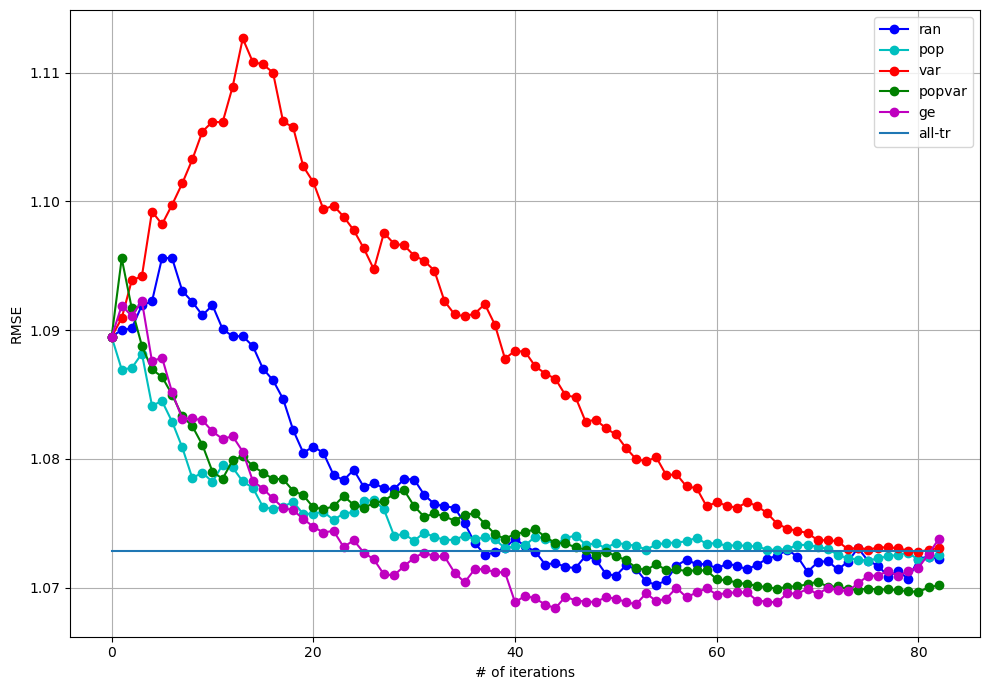

In [107]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

# y_axis = list(range(0, dataset.item_n, w))
# y_axis = list(range(0, results[i][1]['rmse']))


for m, i in list(zip(marker_l, range(len(results)))):
    ax.plot(list(range(0, len(results[i][1]['rmse']))), results[i][1]['rmse'], m, label=results[i][0])
    # ax.plot(y_axis[:], results[i][1]['rmse'], m, label=results[i][0])
    

ax.plot(list(range(0, len(results[0][1]['rmse']))), [fin_acc]*len(list(range(0, len(results[0][1]['rmse'])))),'-', label='all-tr')   
# ax.plot(y_axis[:], [fin_acc]*len(y_axis),'-', label='all-tr')           
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
# plt.title('Non-personalized AL Strategies')

# plt.show()
plt.savefig('./plots/NonPers_mc020424.png', dpi=300)

## RMSE difference

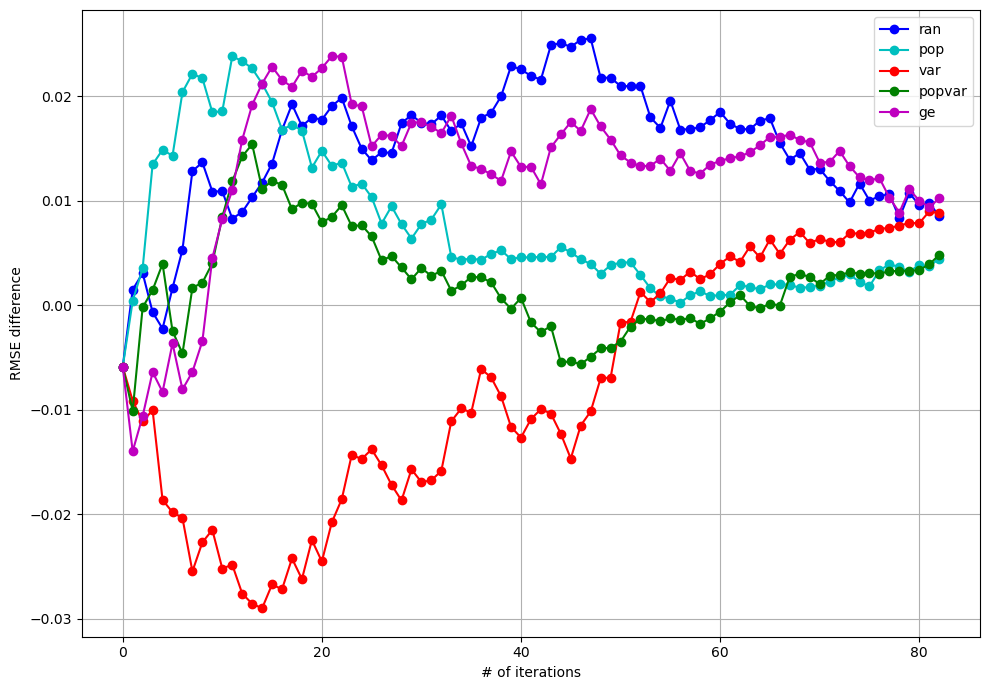

In [108]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    rmse_diff = [a-b for a, b in zip(results[i][1]['rmse_pro'], results[i][1]['rmse_unpro'])]
    ax.plot(list(range(0, len(results[i][1]['rmse']))), rmse_diff, m, label=results[i][0])
    # ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE difference')
# plt.title('Unfairness in different AL methods')

# plt.show()
plt.savefig('./plots/nonpers_rmse_diff_mc020424.png', dpi=300)

## The RMSE of each groups separately

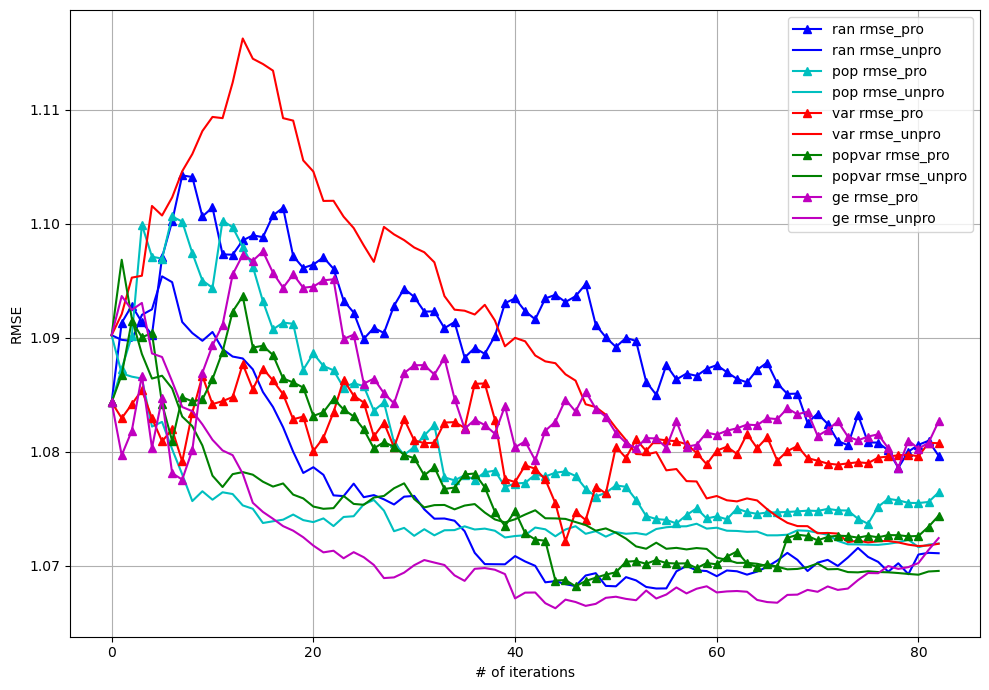

In [109]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

y_axis = list(range(0, dataset.item_n, w))
list(range(0, len(results[i][1]['rmse'])))


for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(list(range(0, len(results[i][1]['rmse_pro']))), results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
    ax.plot(list(range(0, len(results[i][1]['rmse_unpro']))), results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
    # ax.plot(y_axis, results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
    # ax.plot(y_axis, results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
# plt.title('RMSE Plors for Pro & Unpro')
# plt.show()
plt.savefig('./plots/proUnpro_rmse_diff_mc020424.png', dpi=300)

## The count of Small and Large that their info was added at each iteration

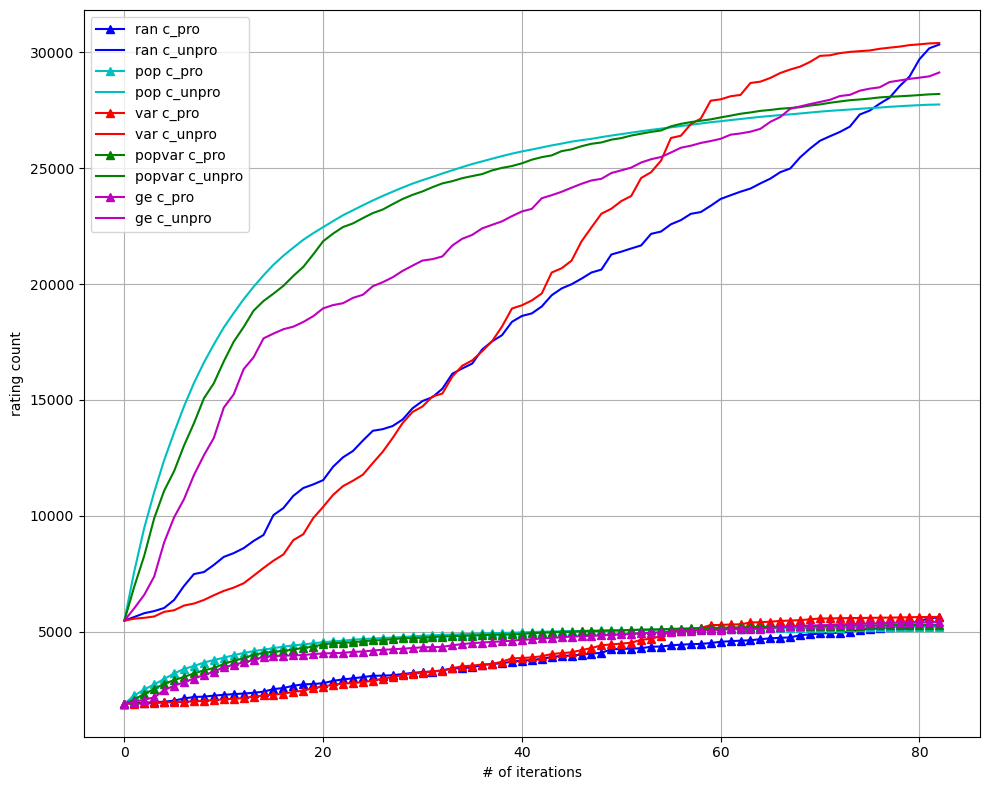

In [110]:
fig, ax = plt.subplots(figsize=(10, 8))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']
X
# y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(list(range(0, len(results[i][1]['c_pro']))), results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
    ax.plot(list(range(0, len(results[i][1]['c_unpro']))), results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')

    
#     ax.plot(y_axis, results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
#     ax.plot(y_axis, results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('rating count')
# plt.title('Pro & Unpro Counts')
# plt.show()
plt.savefig('./plots/proUnpro_rate_c_mc.png', dpi=300)

**<font color='red'>Difference: does this still apply?</font>**
- this number tells us the number of ratings counts by mena dn women.
- pop and popvar both take a lot of ratings initially and then it decreases
    - maybe that is why they have lower RMSE, as they have more data for the majority
    - their RMSE for the unpro group is the lowest
    - RMSE for prot group is almost similar but popvar is slightly lower.
- var takes less ratings initially but a more equal number of men and women
    - that's why it has lower rmse
    - then it kinda grows as it doesn't have any other choice than selecting mroe data from men.
    - so we can say that controversial items with high variance rating, don't have many ratings on them in general but the number of men and women is more equal. (??? There are certain niche items that men adn women disagree on a lot.)
    
- popvar and var have small rmse differences compared to others. Var has smaller rmse difference.

# How popular are the items that have more balanced ratings?

In [113]:
item_l_s_cnt['c'] = item_l_s_cnt['L_c']+item_l_s_cnt['S_c']
# item_f_m_cnt.head()

In [114]:
itemSortedByPop = item_l_s_cnt.sort_values(by='pop')
itemSortedByPop.head()

,item_iid,L_c,S_c,L_med,L_avg,S_med,S_avg,pop,normpop,var,sqrt normpopvar,npop,sqrt npopvar,c
464,464,0.0,2.0,0.0,0.0,5.0,5.000000,2,0,0.000000,0,0.0000,0.000000,2.0
639,639,0.0,3.0,0.0,0.0,4.0,4.333333,3,0,0.222222,0,0.0025,0.011111,3.0
655,655,0.0,3.0,0.0,0.0,5.0,4.666667,3,0,0.222222,0,0.0025,0.011111,3.0
4,4,0.0,3.0,0.0,0.0,3.0,3.000000,3,0,0.666667,0,0.0025,0.033333,3.0
589,589,0.0,3.0,0.0,0.0,5.0,4.666667,3,0,0.222222,0,0.0025,0.011111,3.0


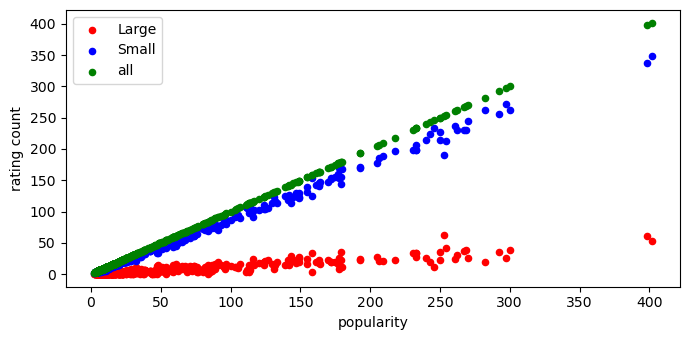

In [115]:

ax1 = itemSortedByPop.plot(kind = 'scatter', x='pop', y='L_c', c='red', label='Large')
ax2 = itemSortedByPop.plot(kind='scatter', x='pop', y='S_c', c='blue', label='Small', ax= ax1)
ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='green', label='all', ax=ax1)

ax1.set_xlabel("popularity")
ax1.set_ylabel("rating count")
plt.show()

In [116]:
from sklearn.metrics import r2_score

print(r2_score(itemSortedByPop['pop'], itemSortedByPop['c']))
print(r2_score(itemSortedByPop['pop'], itemSortedByPop['S_c']))
print(r2_score(itemSortedByPop['pop'], itemSortedByPop['L_c']))

1.0
0.9752421513693403
-0.12769845408863767


- The more popular an item is the more ratings it has. This trend is true for men, but not for women. There's a slight correlation.
- very popular items are not that many and they have more mens' ratings compared to women.
- the more popular an item gets, the less rating from women it gathers, then the accuracy difference increases.

- women's ratings have more variance

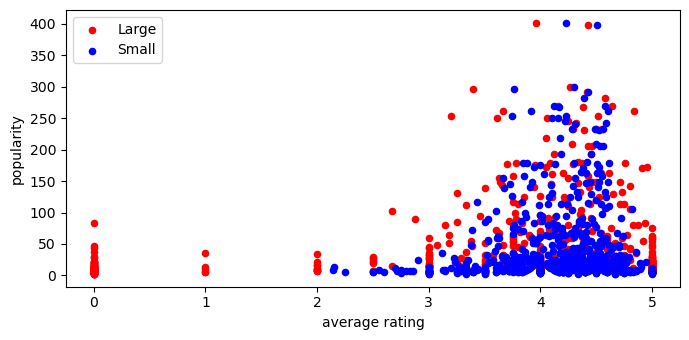

In [117]:

ax1 = itemSortedByPop.plot(kind = 'scatter', y='pop', x='L_avg', c='red', label='Large')
ax2 = itemSortedByPop.plot(kind='scatter', y='pop', x='S_avg', c='blue', label='Small', ax= ax1)
# ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='Green', label='all', ax=ax1)

ax1.set_ylabel("popularity")
ax1.set_xlabel("average rating")
plt.show()

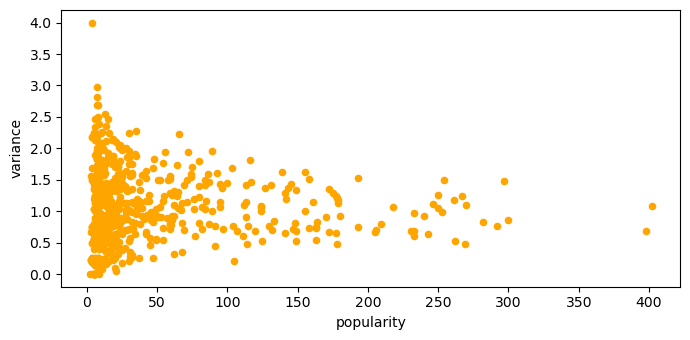

In [118]:
ax1 = itemSortedByPop.plot(kind = 'scatter', y = 'var', x='pop', c='Orange')
# ax2 = itemSortedByPop.plot(kind='scatter', y='pop', x='M_avg', c='Blue', label='male', ax= ax1)
# ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='Green', label='all', ax=ax1)

ax1.set_xlabel("popularity")
ax1.set_ylabel("variance")
plt.show()

In [119]:
itemSortedByPop

,item_iid,L_c,S_c,L_med,L_avg,S_med,S_avg,pop,normpop,var,sqrt normpopvar,npop,sqrt npopvar,c
464,464,0.0,2.0,0.0,0.000000,5.0,5.000000,2,0,0.000000,0,0.0000,0.000000,2.0
639,639,0.0,3.0,0.0,0.000000,4.0,4.333333,3,0,0.222222,0,0.0025,0.011111,3.0
655,655,0.0,3.0,0.0,0.000000,5.0,4.666667,3,0,0.222222,0,0.0025,0.011111,3.0
4,4,0.0,3.0,0.0,0.000000,3.0,3.000000,3,0,0.666667,0,0.0025,0.033333,3.0
589,589,0.0,3.0,0.0,0.000000,5.0,4.666667,3,0,0.222222,0,0.0025,0.011111,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,176,36.0,256.0,5.0,4.416667,5.0,4.429688,292,0,0.758526,0,0.7250,0.645862,292.0
365,365,25.0,272.0,4.0,3.400000,4.0,3.761029,297,0,1.476267,0,0.7375,1.267786,297.0
585,585,38.0,262.0,5.0,4.263158,5.0,4.297710,300,0,0.867289,0,0.7450,0.748586,300.0
320,320,61.0,337.0,5.0,4.426230,5.0,4.510386,398,0,0.682154,0,0.9900,0.678735,398.0


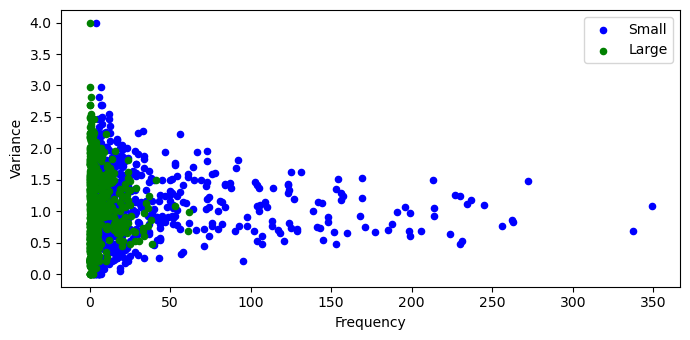

In [120]:
# ax1 = itemSortedByPop.plot(kind = 'scatter', y = 'var', x='M_c', c='Orange')
ax1 = itemSortedByPop.plot(kind='scatter', y='var', x='S_c', c='blue', label='Small')
ax2 = itemSortedByPop.plot(kind='scatter', y='var', x='L_c', c='green', label='Large', ax=ax1)

ax1.set_xlabel("Frequency")
ax1.set_ylabel("Variance")
plt.show()

- There are a lot of items with high popularity and very low variance.
- And the popular items have mostly male ratings.
- So, high variance items have low to medium popularity and also more balanced ratings probably.

# Same ratio experiment

## What if we feed the same ratio of data to the algorithm, what will happen to the accuracy?

In [123]:
#---------------------------------------------
from tqdm import tqdm


def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
    pro_c = []
    unpro_c = []
    
    rmse = []
    rmse_pro = []
    rmse_unpro = []
    
#     vu = []
    
    tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
    # number of items
    n_itm = np.unique(train_df['item']).shape[0]
    i_indx = 0

    pbar = tqdm(desc='while loop', total=n_itm+1)
    while i_indx < n_itm:

        if i_indx%100. == 0.:
            print('sample %i-th item...' %i_indx)
    

        if i_indx != 0:
            # choosing the next item to sample
            chosen_is = srt_it[i_indx:i_indx+win]
            
            
            # filtering for equal proportions
            chosen_df = tr_df[tr_df['item'].isin(chosen_is)]
            
            pro_chosen_df = chosen_df[chosen_df['user'].isin(pro_users_index)]
            
            p_c = pro_chosen_df.shape[0] # count of how many female ratings
            
            # select as many male ratings as women's ratings
            unpro_chosen_df = chosen_df[~chosen_df['user'].isin(pro_users_index)][:p_c]

            
            print(p_c, unpro_chosen_df.shape[0])
            
            
            tr_iter = pd.concat([tr_iter, 
                                pro_chosen_df,
                                unpro_chosen_df]).drop_duplicates()

            # Sample based on item popularity but without replacement.
            # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
#             tr_iter = pd.concat([tr_iter, 
#                                   tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()
        
        else:
            tr_iter = knw_df

 
            
        # turn the data into a Surprise readbale file
        trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


        # fitting to the model
        algo.fit(trainset_act)
        preds = algo.test(tes)

        # evaluating the outcome
        rmse.append(accuracy.rmse(preds, verbose=False))
        # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


        # pro & unpro RMSE
        pro_, unpro_ = seperate_preds(preds)    
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#         # value fairness
#         vu.append(value_unfairness(pd.DataFrame(preds)))


        # pro/unpro count
        pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
        unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])
        
        
        #----------------------------------next iteration---------------------------------
        i_indx += win
        pbar.update(1)
       
    
    pbar.close()  
    return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    
    


if __name__ == "__main__":

    def comp_paral (akey):
        # strtgs[akey] is the sorted list of items based on a strategy
        return(akey, ac_proc(train_df, known_df, testset, w, strtgs[akey], svd_sup))
        # (tr_df, knw_df, tes, win, srt_it, algo)
     
    start = timeit.default_timer()
    import multiprocess as mp


    #------------------------item lists (act sorted & rand shuffled)---------------------
    # unique sorted items
    # if you use set() or np.unique(), they will disorder the list!
    sorted_i_pop = item_pop_df['item_iid'].tolist()

    # suffled list of items
    shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

    # uncertainty - variance
    sorted_i_v = item_uc_var_df['item_iid'].tolist()

    # items order by their Sqrt(norm pop) * Var
    sorted_i_spv = item_popvar_df['item_iid'].tolist()

    # sorted based on their contribution to RMSE
    sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

    strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
              'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}

#     strtgs = {'ran':shuffled_i_ran}
    

    
    #------------------------ test set & algo & window ---------------------
    # the known set, a part of the training set
    # known_n = 0.02
    # known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
    known_df = initial_train_df
    
    
    # build the test set
    testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()
    
    
    svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
#     algo = SVD()

    w = 10   # window of w items
    
    
    #------------------------ function ---------------------
    pool = mp.Pool(processes=10)
    results = pool.map(comp_paral, list(strtgs.keys()))
#     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))


while loop:   0%|                                       | 0/682 [00:00<?, ?it/s]

sample 0-th item...sample 0-th item...sample 0-th item...sample 0-th item...sample 0-th item...






while loop:   0%|                               | 1/682 [00:00<01:21,  8.34it/s]

14304 175130  14175 304


while loop:   0%|                               | 1/682 [00:00<01:24,  8.06it/s]

130


11 11


while loop:   0%|                               | 2/682 [00:00<01:20,  8.46it/s]

14 14


while loop:   0%|                               | 2/682 [00:00<01:21,  8.30it/s]

104162  16104162 

16

while loop:   0%|                               | 2/682 [00:00<01:24,  8.06it/s]


240 240


while loop:   0%|▏                              | 3/682 [00:00<01:19,  8.51it/s]

30 30


while loop:   0%|▏                              | 3/682 [00:00<01:21,  8.37it/s]

19 19


while loop:   0%|▏                              | 3/682 [00:00<01:23,  8.18it/s]

122 

while loop:   0%|▏                              | 3/682 [00:00<01:23,  8.09it/s]

122
254 254


while loop:   0%|▏                              | 3/682 [00:00<01:27,  7.76it/s]

202 202


while loop:   1%|▏                              | 4/682 [00:00<01:19,  8.49it/s]

64 64


while loop:   1%|▏                              | 4/682 [00:00<01:19,  8.50it/s]

23 23


while loop:   1%|▏                              | 4/682 [00:00<01:23,  8.08it/s]

88 88


while loop:   1%|▏                              | 4/682 [00:00<01:26,  7.80it/s]

199 199


while loop:   1%|▏                              | 4/682 [00:00<01:30,  7.50it/s]

201 201


while loop:   1%|▏                              | 5/682 [00:00<01:20,  8.43it/s]

20

while loop:   1%|▏                              | 5/682 [00:00<01:19,  8.49it/s]

 20
39 39


while loop:   1%|▏                              | 5/682 [00:00<01:25,  7.94it/s]

67 67


while loop:   1%|▏                              | 5/682 [00:00<01:30,  7.48it/s]

109 109


while loop:   1%|▏                              | 5/682 [00:00<01:33,  7.22it/s]

211 211


while loop:   1%|▎                              | 6/682 [00:00<01:20,  8.44it/s]

63 1663 
16


while loop:   1%|▎                              | 6/682 [00:00<01:26,  7.80it/s]

56 56


while loop:   1%|▎                              | 6/682 [00:00<01:32,  7.28it/s]

110 110


while loop:   1%|▎                              | 6/682 [00:00<01:37,  6.95it/s]

168 168


while loop:   1%|▎                              | 7/682 [00:00<01:20,  8.41it/s]

59 59

while loop:   1%|▎                              | 7/682 [00:00<01:21,  8.29it/s]


17 17


while loop:   1%|▎                              | 7/682 [00:00<01:27,  7.68it/s]

119 119


while loop:   1%|▎                              | 7/682 [00:00<01:35,  7.09it/s]

99 99


while loop:   1%|▎                              | 8/682 [00:00<01:20,  8.37it/s]

16 16


while loop:   1%|▎                              | 8/682 [00:00<01:21,  8.24it/s]

34 34


while loop:   1%|▎                              | 7/682 [00:00<01:40,  6.70it/s]

113 113


while loop:   1%|▎                              | 8/682 [00:01<01:28,  7.63it/s]

80 80


while loop:   1%|▍                              | 9/682 [00:01<01:20,  8.33it/s]

7 7


while loop:   1%|▍                              | 9/682 [00:01<01:22,  8.17it/s]

40 40


while loop:   1%|▎                              | 8/682 [00:01<01:37,  6.92it/s]

130 130


while loop:   1%|▎                              | 8/682 [00:01<01:43,  6.54it/s]

131 131


while loop:   1%|▍                              | 9/682 [00:01<01:29,  7.48it/s]

106 106


while loop:   1%|▍                              | 9/682 [00:01<01:40,  6.72it/s]

120 120


while loop:   1%|▍                              | 9/682 [00:01<01:46,  6.34it/s]

100 100


while loop:   1%|▍                             | 10/682 [00:01<01:48,  6.17it/s]

sample 100-th item...
47 47


while loop:   1%|▍                             | 10/682 [00:01<01:50,  6.10it/s]

sample 100-th item...
69 69


while loop:   1%|▍                             | 10/682 [00:01<01:56,  5.75it/s]

sample 100-th item...
59 59


while loop:   2%|▍                             | 11/682 [00:01<01:41,  6.60it/s]

59 59


while loop:   2%|▍                             | 11/682 [00:01<01:42,  6.54it/s]

60 60


while loop:   1%|▍                             | 10/682 [00:01<02:05,  5.33it/s]

sample 100-th item...
90 90


while loop:   2%|▍                             | 11/682 [00:01<01:51,  6.02it/s]

79 79


while loop:   2%|▌                             | 12/682 [00:01<01:36,  6.97it/s]

61 61


while loop:   2%|▌                             | 12/682 [00:01<01:36,  6.94it/s]

46 46

while loop:   1%|▍                             | 10/682 [00:01<02:11,  5.09it/s]


sample 100-th item...
73 73


while loop:   2%|▍                             | 11/682 [00:01<02:01,  5.53it/s]

118 118


while loop:   2%|▌                             | 13/682 [00:01<01:32,  7.21it/s]

18 18


while loop:   2%|▌                             | 13/682 [00:01<01:33,  7.13it/s]

47 3247 
32


while loop:   2%|▍                             | 11/682 [00:01<02:06,  5.31it/s]

88 88


while loop:   2%|▌                             | 14/682 [00:01<01:30,  7.37it/s]

55 55


while loop:   2%|▌                             | 12/682 [00:01<01:58,  5.66it/s]

24 24127
 127


while loop:   2%|▌                             | 13/682 [00:01<01:44,  6.39it/s]

56 56


while loop:   2%|▌                             | 12/682 [00:01<02:03,  5.42it/s]

104 104


while loop:   2%|▋                             | 15/682 [00:01<01:29,  7.47it/s]

127 127


while loop:   2%|▋                             | 15/682 [00:01<01:30,  7.35it/s]

15 15


while loop:   2%|▌                             | 14/682 [00:02<01:42,  6.49it/s]

27 27


while loop:   2%|▌                             | 13/682 [00:02<01:57,  5.70it/s]

104 104


while loop:   2%|▋                             | 16/682 [00:02<01:29,  7.48it/s]

56 56


while loop:   2%|▋                             | 16/682 [00:02<01:29,  7.43it/s]

43

while loop:   2%|▌                             | 13/682 [00:02<02:02,  5.47it/s]

 43
87 87


while loop:   2%|▋                             | 15/682 [00:02<01:42,  6.50it/s]

77 77


while loop:   2%|▌                             | 14/682 [00:02<01:56,  5.73it/s]

74 74


while loop:   2%|▋                             | 17/682 [00:02<01:29,  7.45it/s]

45 45


while loop:   2%|▋                             | 17/682 [00:02<01:29,  7.43it/s]

91 91


while loop:   2%|▌                             | 14/682 [00:02<02:01,  5.51it/s]

65 65


while loop:   2%|▋                             | 16/682 [00:02<01:42,  6.49it/s]

68 68


while loop:   3%|▊                             | 18/682 [00:02<01:29,  7.40it/s]

52 52


while loop:   2%|▋                             | 15/682 [00:02<01:57,  5.67it/s]

98 98


while loop:   3%|▊                             | 18/682 [00:02<01:29,  7.38it/s]

46 46


while loop:   2%|▋                             | 15/682 [00:02<02:01,  5.50it/s]

78 8278 
82


while loop:   3%|▊                             | 19/682 [00:02<01:30,  7.34it/s]

56 56


while loop:   3%|▊                             | 19/682 [00:02<01:29,  7.39it/s]

49 49


while loop:   2%|▋                             | 16/682 [00:02<01:58,  5.63it/s]

40 40


while loop:   3%|▊                             | 18/682 [00:02<01:43,  6.40it/s]

54 54


while loop:   3%|▉                             | 20/682 [00:02<01:30,  7.31it/s]

sample 200-th item...
47 47


while loop:   3%|▉                             | 20/682 [00:02<01:30,  7.33it/s]

sample 200-th item...
69

while loop:   2%|▋                             | 16/682 [00:02<02:02,  5.45it/s]

 69
31 31


while loop:   2%|▋                             | 17/682 [00:02<01:59,  5.58it/s]

80 80


while loop:   3%|▉                             | 21/682 [00:02<01:31,  7.21it/s]

20 20


while loop:   3%|▊                             | 19/682 [00:02<01:44,  6.32it/s]

51 51


while loop:   3%|▉                             | 21/682 [00:02<01:31,  7.21it/s]

19 19


while loop:   2%|▋                             | 17/682 [00:02<02:01,  5.46it/s]

47 47


while loop:   3%|▊                             | 18/682 [00:02<01:59,  5.55it/s]

48 48


while loop:   3%|▉                             | 22/682 [00:02<01:32,  7.13it/s]

79 79


while loop:   3%|▉                             | 22/682 [00:02<01:32,  7.14it/s]

69 69


while loop:   3%|▉                             | 20/682 [00:02<01:45,  6.25it/s]

sample 200-th item...
88 88


while loop:   3%|▊                             | 18/682 [00:03<02:02,  5.44it/s]

31 31


while loop:   3%|█                             | 23/682 [00:03<01:32,  7.09it/s]

44 44


while loop:   3%|█                             | 23/682 [00:03<01:33,  7.06it/s]

39 39


while loop:   3%|▊                             | 19/682 [00:03<02:00,  5.49it/s]

30 30


while loop:   3%|▉                             | 21/682 [00:03<01:47,  6.16it/s]

49 49


while loop:   3%|▊                             | 19/682 [00:03<02:03,  5.39it/s]

40 40

while loop:   4%|█                             | 24/682 [00:03<01:33,  7.01it/s]


62 62


while loop:   4%|█                             | 24/682 [00:03<01:34,  6.97it/s]

36 36


while loop:   3%|▉                             | 22/682 [00:03<01:47,  6.12it/s]

50 

while loop:   3%|▉                             | 20/682 [00:03<02:02,  5.42it/s]

50sample 200-th item...

87 87


while loop:   3%|▉                             | 20/682 [00:03<02:04,  5.32it/s]

sample 200-th item...
37 37


while loop:   4%|█                             | 25/682 [00:03<01:50,  5.93it/s]

85 85


while loop:   4%|█                             | 25/682 [00:03<01:48,  6.03it/s]

42 42


while loop:   3%|█                             | 23/682 [00:03<01:49,  6.02it/s]

76 76


while loop:   3%|▉                             | 21/682 [00:03<02:03,  5.34it/s]

57 57


while loop:   4%|█▏                            | 26/682 [00:03<01:47,  6.12it/s]

40 

while loop:   4%|█▏                            | 26/682 [00:03<01:45,  6.21it/s]

40


while loop:   3%|▉                             | 21/682 [00:03<02:05,  5.27it/s]

71 7134 
34


while loop:   4%|█                             | 24/682 [00:03<01:50,  5.97it/s]

65 65


while loop:   3%|▉                             | 22/682 [00:03<02:03,  5.33it/s]

19 19


while loop:   4%|█▏                            | 27/682 [00:03<01:45,  6.21it/s]

52 52

while loop:   4%|█▏                            | 27/682 [00:03<01:44,  6.27it/s]


60 60


while loop:   3%|▉                             | 22/682 [00:03<02:07,  5.19it/s]

41 41


while loop:   3%|█                             | 23/682 [00:03<02:05,  5.27it/s]

67 67


while loop:   4%|█                             | 25/682 [00:03<02:07,  5.15it/s]

62 62


while loop:   4%|█▏                            | 28/682 [00:03<01:44,  6.28it/s]

61 61


while loop:   4%|█▏                            | 28/682 [00:03<01:43,  6.32it/s]

16 16


while loop:   3%|█                             | 23/682 [00:04<02:07,  5.16it/s]

33 33


while loop:   4%|█                             | 24/682 [00:04<02:05,  5.26it/s]

19

while loop:   4%|█▎                            | 29/682 [00:04<01:43,  6.33it/s]

 19
23

while loop:   4%|█▏                            | 26/682 [00:04<02:03,  5.30it/s]

 23
116 116

while loop:   4%|█▎                            | 29/682 [00:04<01:42,  6.34it/s]


81 81


while loop:   4%|█                             | 24/682 [00:04<02:08,  5.13it/s]

34 34


while loop:   4%|█▎                            | 30/682 [00:04<01:43,  6.31it/s]

sample 300-th item...
131 131


while loop:   4%|█▎                            | 30/682 [00:04<01:43,  6.32it/s]

sample 300-th item...
88 88


while loop:   4%|█▏                            | 27/682 [00:04<02:02,  5.36it/s]

35 35


while loop:   4%|█                             | 25/682 [00:04<02:18,  4.74it/s]

22 22


while loop:   5%|█▎                            | 31/682 [00:04<01:44,  6.23it/s]

100 100

while loop:   5%|█▎                            | 31/682 [00:04<01:43,  6.26it/s]


50 50


while loop:   4%|█▏                            | 28/682 [00:04<02:00,  5.44it/s]

56 56


while loop:   4%|█                             | 25/682 [00:04<02:22,  4.60it/s]

34 34


while loop:   4%|█▏                            | 26/682 [00:04<02:15,  4.84it/s]

30 30


while loop:   5%|█▍                            | 32/682 [00:04<01:44,  6.20it/s]

43 43


while loop:   5%|█▍                            | 32/682 [00:04<01:44,  6.22it/s]

47 47


while loop:   4%|█▎                            | 29/682 [00:04<02:00,  5.44it/s]

47 47


while loop:   4%|█▏                            | 26/682 [00:04<02:19,  4.71it/s]

22 22


while loop:   4%|█▏                            | 27/682 [00:04<02:12,  4.93it/s]

10 10


while loop:   5%|█▍                            | 33/682 [00:04<01:45,  6.14it/s]

60 6072
 72


while loop:   4%|█▎                            | 30/682 [00:04<02:00,  5.43it/s]

sample 300-th item...
71 71


while loop:   4%|█▏                            | 27/682 [00:04<02:16,  4.82it/s]

20 20


while loop:   5%|█▍                            | 34/682 [00:04<01:45,  6.14it/s]

76 76

while loop:   5%|█▍                            | 34/682 [00:04<01:46,  6.07it/s]


122 122


while loop:   4%|█▏                            | 28/682 [00:04<02:12,  4.95it/s]

16 16


while loop:   5%|█▎                            | 31/682 [00:04<01:59,  5.43it/s]

92 92


while loop:   5%|█▌                            | 35/682 [00:05<01:46,  6.07it/s]

66 66


while loop:   5%|█▌                            | 35/682 [00:05<01:48,  5.98it/s]

66 66

while loop:   4%|█▏                            | 28/682 [00:05<02:14,  4.86it/s]


16 16


while loop:   4%|█▎                            | 29/682 [00:05<02:09,  5.03it/s]

9 9


while loop:   5%|█▍                            | 32/682 [00:05<02:00,  5.37it/s]

23 23


while loop:   5%|█▌                            | 36/682 [00:05<01:47,  5.99it/s]

44 44


while loop:   5%|█▌                            | 36/682 [00:05<01:49,  5.91it/s]

49 49


while loop:   4%|█▎                            | 29/682 [00:05<02:12,  4.91it/s]

23 23


while loop:   4%|█▎                            | 30/682 [00:05<02:08,  5.06it/s]

sample 300-th item...
19 19


while loop:   5%|█▍                            | 33/682 [00:05<02:01,  5.33it/s]

67 67


while loop:   5%|█▋                            | 37/682 [00:05<01:48,  5.96it/s]

17 17


while loop:   5%|█▋                            | 37/682 [00:05<01:50,  5.84it/s]

44 44


while loop:   4%|█▎                            | 30/682 [00:05<02:12,  4.93it/s]

sample 300-th item...
20 20


while loop:   5%|█▎                            | 31/682 [00:05<02:09,  5.03it/s]

11 11


while loop:   5%|█▍                            | 34/682 [00:05<02:02,  5.30it/s]

38 38


while loop:   6%|█▋                            | 38/682 [00:05<01:49,  5.90it/s]

49 49


while loop:   6%|█▋                            | 38/682 [00:05<01:51,  5.77it/s]

96 96


while loop:   5%|█▎                            | 31/682 [00:05<02:12,  4.90it/s]

21 21


while loop:   5%|█▍                            | 32/682 [00:05<02:09,  5.03it/s]

9 9


while loop:   6%|█▋                            | 39/682 [00:05<01:50,  5.84it/s]

23 

while loop:   5%|█▌                            | 35/682 [00:05<02:03,  5.24it/s]

23
36 36


while loop:   6%|█▋                            | 39/682 [00:05<01:52,  5.73it/s]

53 53


while loop:   5%|█▍                            | 32/682 [00:05<02:13,  4.88it/s]

18 18


while loop:   5%|█▍                            | 33/682 [00:05<02:09,  5.02it/s]

39 39


while loop:   5%|█▌                            | 36/682 [00:05<02:04,  5.19it/s]

28 28


while loop:   6%|█▊                            | 40/682 [00:06<02:07,  5.05it/s]

sample 400-th item...
48 48


while loop:   6%|█▊                            | 40/682 [00:06<02:06,  5.07it/s]

sample 400-th item...
62 62


while loop:   5%|█▍                            | 33/682 [00:06<02:13,  4.88it/s]

17 17


while loop:   5%|█▍                            | 34/682 [00:06<02:09,  4.99it/s]

15 15


while loop:   5%|█▋                            | 37/682 [00:06<02:04,  5.16it/s]

25 25


while loop:   6%|█▊                            | 41/682 [00:06<02:02,  5.21it/s]

104 104


while loop:   6%|█▊                            | 41/682 [00:06<02:04,  5.17it/s]

32 32


while loop:   5%|█▍                            | 34/682 [00:06<02:12,  4.87it/s]

12 12


while loop:   5%|█▌                            | 35/682 [00:06<02:09,  4.99it/s]

16 16


while loop:   6%|█▋                            | 38/682 [00:06<02:04,  5.16it/s]

33 33


while loop:   6%|█▊                            | 42/682 [00:06<02:00,  5.31it/s]

54 54


while loop:   6%|█▊                            | 42/682 [00:06<02:02,  5.22it/s]

78 78


while loop:   5%|█▌                            | 35/682 [00:06<02:13,  4.86it/s]

16 16


while loop:   5%|█▌                            | 36/682 [00:06<02:10,  4.96it/s]

31 31


while loop:   6%|█▋                            | 39/682 [00:06<02:05,  5.12it/s]

28 28


while loop:   6%|█▉                            | 43/682 [00:06<01:59,  5.36it/s]

24 24


while loop:   6%|█▉                            | 43/682 [00:06<02:01,  5.27it/s]

87 87


while loop:   5%|█▌                            | 36/682 [00:06<02:13,  4.84it/s]

11 11


while loop:   5%|█▋                            | 37/682 [00:06<02:10,  4.94it/s]

18 18


while loop:   6%|█▉                            | 44/682 [00:06<01:58,  5.38it/s]

50 50


while loop:   6%|█▉                            | 44/682 [00:06<02:01,  5.24it/s]

113 113


while loop:   6%|█▊                            | 40/682 [00:06<02:18,  4.64it/s]

sample 400-th item...
24 24


while loop:   5%|█▋                            | 37/682 [00:06<02:12,  4.88it/s]

13 13


while loop:   7%|█▉                            | 45/682 [00:06<01:58,  5.38it/s]

54 54


while loop:   6%|█▋                            | 38/682 [00:06<02:11,  4.91it/s]

12 12


while loop:   7%|█▉                            | 45/682 [00:06<02:02,  5.18it/s]

73 73


while loop:   6%|█▊                            | 41/682 [00:07<02:15,  4.72it/s]

48 48


while loop:   7%|██                            | 46/682 [00:07<01:58,  5.38it/s]

32 32


while loop:   6%|█▋                            | 38/682 [00:07<02:12,  4.87it/s]

12 12


while loop:   6%|█▋                            | 39/682 [00:07<02:10,  4.94it/s]

14 14


while loop:   7%|██                            | 46/682 [00:07<02:04,  5.12it/s]

185 185


while loop:   6%|█▊                            | 42/682 [00:07<02:14,  4.77it/s]

29 29


while loop:   7%|██                            | 47/682 [00:07<01:58,  5.38it/s]

78 78


while loop:   6%|█▋                            | 39/682 [00:07<02:12,  4.84it/s]

7 7


while loop:   7%|██                            | 47/682 [00:07<02:05,  5.07it/s]

79 79


while loop:   6%|█▊                            | 40/682 [00:07<02:25,  4.43it/s]

sample 400-th item...
17 17


while loop:   6%|█▉                            | 43/682 [00:07<02:13,  4.79it/s]

29 29


while loop:   7%|██                            | 48/682 [00:07<01:59,  5.32it/s]

22 22


while loop:   7%|██                            | 48/682 [00:07<02:06,  5.00it/s]

16 16


while loop:   6%|█▊                            | 40/682 [00:07<02:26,  4.37it/s]

sample 400-th item...
15 15


while loop:   6%|█▊                            | 41/682 [00:07<02:21,  4.53it/s]

22 22


while loop:   6%|█▉                            | 44/682 [00:07<02:11,  4.84it/s]

29 29


while loop:   7%|██▏                           | 49/682 [00:07<01:59,  5.31it/s]

47 47


while loop:   7%|██▏                           | 49/682 [00:07<02:08,  4.92it/s]

32 32


while loop:   6%|█▊                            | 42/682 [00:07<02:18,  4.61it/s]

1223  1223



while loop:   7%|█▉                            | 45/682 [00:07<02:11,  4.84it/s]

35 35


while loop:   7%|██▏                           | 50/682 [00:07<01:58,  5.33it/s]

sample 500-th item...
109 109


while loop:   7%|██▏                           | 50/682 [00:08<02:09,  4.87it/s]

sample 500-th item...
46 46


while loop:   6%|█▊                            | 42/682 [00:08<02:18,  4.61it/s]

8 8


while loop:   6%|█▉                            | 43/682 [00:08<02:17,  4.66it/s]

16 

while loop:   7%|██                            | 46/682 [00:08<02:11,  4.83it/s]

16
35 35


while loop:   7%|██▏                           | 51/682 [00:08<02:00,  5.23it/s]

93 93


while loop:   7%|██▏                           | 51/682 [00:08<02:11,  4.79it/s]

11 11


while loop:   6%|█▉                            | 43/682 [00:08<02:17,  4.64it/s]

11 11


while loop:   6%|█▉                            | 44/682 [00:08<02:16,  4.68it/s]

8

while loop:   7%|██                            | 47/682 [00:08<02:12,  4.81it/s]

 8
14 14


while loop:   8%|██▎                           | 52/682 [00:08<01:59,  5.25it/s]

36 36


while loop:   8%|██▎                           | 52/682 [00:08<02:12,  4.75it/s]

966  966



while loop:   7%|█▉                            | 45/682 [00:08<02:15,  4.69it/s]

28 2811

while loop:   7%|██                            | 48/682 [00:08<02:12,  4.78it/s]


 1156
 56


while loop:   7%|█▉                            | 45/682 [00:08<02:14,  4.74it/s]

12 12


while loop:   8%|██▎                           | 53/682 [00:08<02:13,  4.71it/s]

74 

while loop:   7%|██                            | 46/682 [00:08<02:12,  4.79it/s]

74
24 24

while loop:   8%|██▍                           | 54/682 [00:08<02:03,  5.09it/s]


4 4


while loop:   7%|██▏                           | 49/682 [00:08<02:13,  4.74it/s]

18 18


while loop:   7%|██                            | 46/682 [00:08<02:15,  4.70it/s]

4 4


while loop:   7%|██                            | 47/682 [00:08<02:13,  4.75it/s]

7 7


while loop:   8%|██▍                           | 54/682 [00:08<02:14,  4.65it/s]

sample 500-th item...
7 497
 49


while loop:   8%|██▍                           | 55/682 [00:08<02:18,  4.52it/s]

66 66


while loop:   7%|██                            | 47/682 [00:09<02:15,  4.67it/s]

11 11

while loop:   7%|██                            | 48/682 [00:09<02:14,  4.72it/s]


26 26


while loop:   7%|██▏                           | 51/682 [00:09<02:13,  4.74it/s]

16 16


while loop:   8%|██▍                           | 56/682 [00:09<02:13,  4.69it/s]

39 39


while loop:   8%|██▍                           | 55/682 [00:09<02:29,  4.18it/s]

79 79


while loop:   7%|██▏                           | 49/682 [00:09<02:13,  4.76it/s]

17 17


while loop:   7%|██                            | 48/682 [00:09<02:15,  4.67it/s]

5 5


while loop:   8%|██▎                           | 52/682 [00:09<02:13,  4.71it/s]

25 25


while loop:   8%|██▌                           | 57/682 [00:09<02:11,  4.74it/s]

34 34


while loop:   8%|██▍                           | 56/682 [00:09<02:26,  4.29it/s]

36 36


while loop:   7%|██▏                           | 50/682 [00:09<02:13,  4.74it/s]

sample 500-th item...

while loop:   7%|██▏                           | 49/682 [00:09<02:14,  4.70it/s]


58  58



while loop:   8%|██▎                           | 53/682 [00:09<02:13,  4.70it/s]

11 11


while loop:   9%|██▌                           | 58/682 [00:09<02:10,  4.77it/s]

73 73


while loop:   8%|██▌                           | 57/682 [00:09<02:22,  4.39it/s]

21 21


while loop:   7%|██▏                           | 50/682 [00:09<02:13,  4.74it/s]

sample 500-th item...
7 7


while loop:   7%|██▏                           | 51/682 [00:09<02:14,  4.70it/s]

12 12


while loop:   8%|██▍                           | 54/682 [00:09<02:13,  4.69it/s]

12 12


while loop:   9%|██▌                           | 59/682 [00:09<02:10,  4.79it/s]

68 68


while loop:   9%|██▌                           | 58/682 [00:09<02:20,  4.43it/s]

11 11


while loop:   7%|██▏                           | 51/682 [00:09<02:14,  4.71it/s]

9 9


while loop:   8%|██▎                           | 52/682 [00:09<02:14,  4.68it/s]

29 29


while loop:   9%|██▋                           | 60/682 [00:09<02:11,  4.73it/s]

sample 600-th item...
70 70


while loop:   8%|██▍                           | 55/682 [00:10<02:29,  4.21it/s]

9 9


while loop:   9%|██▌                           | 59/682 [00:10<02:18,  4.49it/s]

24 24


while loop:   8%|██▎                           | 52/682 [00:10<02:13,  4.71it/s]

8 8


while loop:   8%|██▎                           | 53/682 [00:10<02:14,  4.69it/s]

4 4


while loop:   9%|██▋                           | 61/682 [00:10<02:12,  4.70it/s]

39 39


while loop:   8%|██▍                           | 56/682 [00:10<02:23,  4.36it/s]

6 6


while loop:   9%|██▋                           | 60/682 [00:10<02:18,  4.50it/s]

sample 600-th item...
36 36


while loop:   8%|██▎                           | 53/682 [00:10<02:13,  4.70it/s]

8 8


while loop:   8%|██▍                           | 54/682 [00:10<02:13,  4.69it/s]

19 19


while loop:   9%|██▋                           | 62/682 [00:10<02:11,  4.70it/s]

64 64


while loop:   8%|██▌                           | 57/682 [00:10<02:20,  4.45it/s]

5 5


while loop:   9%|██▋                           | 61/682 [00:10<02:18,  4.49it/s]

10 10


while loop:   8%|██▍                           | 54/682 [00:10<02:14,  4.68it/s]

3 3


while loop:   9%|██▊                           | 63/682 [00:10<02:13,  4.64it/s]

69 69


while loop:   8%|██▍                           | 55/682 [00:10<02:28,  4.22it/s]

8 8


while loop:   9%|██▌                           | 58/682 [00:10<02:18,  4.50it/s]

9 9


while loop:   9%|██▋                           | 62/682 [00:10<02:18,  4.47it/s]

9 9


while loop:   9%|██▊                           | 64/682 [00:10<02:13,  4.62it/s]

19 19


while loop:   8%|██▍                           | 55/682 [00:10<02:27,  4.24it/s]

8 8


while loop:   8%|██▍                           | 56/682 [00:10<02:24,  4.33it/s]

7 7


while loop:   9%|██▌                           | 59/682 [00:10<02:17,  4.53it/s]

6 6


while loop:   9%|██▊                           | 63/682 [00:10<02:17,  4.49it/s]

18 18


while loop:  10%|██▊                           | 65/682 [00:11<02:14,  4.60it/s]

41 41


while loop:   8%|██▍                           | 56/682 [00:11<02:23,  4.36it/s]

4 4


while loop:   8%|██▌                           | 57/682 [00:11<02:21,  4.41it/s]

5 5


while loop:   9%|██▋                           | 60/682 [00:11<02:15,  4.60it/s]

sample 600-th item...
7 7


while loop:   9%|██▊                           | 64/682 [00:11<02:18,  4.46it/s]

2 2


while loop:  10%|██▉                           | 66/682 [00:11<02:14,  4.57it/s]

61 61


while loop:   8%|██▌                           | 57/682 [00:11<02:20,  4.46it/s]

5 5


while loop:   9%|██▌                           | 58/682 [00:11<02:19,  4.47it/s]

14 14


while loop:   9%|██▋                           | 61/682 [00:11<02:14,  4.61it/s]

7 7


while loop:  10%|██▊                           | 65/682 [00:11<02:17,  4.49it/s]

14 14


while loop:   9%|██▌                           | 58/682 [00:11<02:18,  4.52it/s]

4 4


while loop:  10%|██▉                           | 67/682 [00:11<02:16,  4.51it/s]

44 44


while loop:   9%|██▌                           | 59/682 [00:11<02:17,  4.53it/s]

6 6


while loop:   9%|██▋                           | 62/682 [00:11<02:14,  4.60it/s]

7 7


while loop:  10%|██▉                           | 66/682 [00:11<02:15,  4.53it/s]

11 11


while loop:   9%|██▌                           | 59/682 [00:11<02:16,  4.55it/s]

4 4


while loop:  10%|██▉                           | 68/682 [00:11<02:17,  4.48it/s]

1 

while loop:   9%|██▋                           | 60/682 [00:11<02:16,  4.54it/s]

1sample 600-th item...

12 12


while loop:   9%|██▊                           | 63/682 [00:11<02:14,  4.59it/s]

5 5


while loop:  10%|██▉                           | 67/682 [00:11<02:15,  4.54it/s]

6 6


while loop:   9%|██▋                           | 60/682 [00:11<02:15,  4.58it/s]

sample 600-th item...
9 9


while loop:   9%|██▋                           | 61/682 [00:11<02:14,  4.60it/s]

6 6


while loop:   9%|██▊                           | 64/682 [00:11<02:14,  4.58it/s]

9 9


while loop:  10%|██▉                           | 68/682 [00:12<02:17,  4.48it/s]

2 2


while loop:   9%|██▋                           | 61/682 [00:12<02:15,  4.59it/s]

5 5


while loop:   9%|██▋                           | 62/682 [00:12<02:14,  4.60it/s]

8 8


while loop:  10%|██▊                           | 65/682 [00:12<02:14,  4.58it/s]

8 8


while loop:   9%|██▋                           | 62/682 [00:12<02:15,  4.58it/s]

7 7


while loop:   9%|██▊                           | 63/682 [00:12<02:15,  4.58it/s]

1 1


while loop:  10%|██▉                           | 66/682 [00:12<02:15,  4.55it/s]

13 13


while loop:   9%|██▊                           | 63/682 [00:12<02:14,  4.61it/s]

3 3


while loop:   9%|██▊                           | 64/682 [00:12<02:14,  4.60it/s]

8 8


while loop:  10%|██▉                           | 67/682 [00:12<02:14,  4.56it/s]

14 14


while loop:   9%|██▊                           | 64/682 [00:12<02:13,  4.64it/s]

7 7


while loop:  10%|██▊                           | 65/682 [00:12<02:14,  4.60it/s]

7 7


while loop:  10%|██▉                           | 68/682 [00:12<02:14,  4.57it/s]

0 0


while loop:  10%|██▊                           | 65/682 [00:13<02:12,  4.64it/s]

3 3


while loop:  10%|██▉                           | 66/682 [00:13<02:13,  4.61it/s]

10 10


while loop:  10%|██▉                           | 66/682 [00:13<02:12,  4.65it/s]

5 5


while loop:  10%|██▉                           | 67/682 [00:13<02:12,  4.63it/s]

6 6


while loop:  10%|██▉                           | 67/682 [00:13<02:10,  4.70it/s]

3 3


while loop:  10%|██▉                           | 68/682 [00:13<02:11,  4.67it/s]

0 0


while loop:  10%|██▉                           | 68/682 [00:13<02:09,  4.75it/s]

0 0


while loop:  10%|███                           | 69/682 [00:13<02:02,  4.98it/s]


Process Time: 13.93 secs


/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/sipei/micromamba/envs/fairness_env/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_track

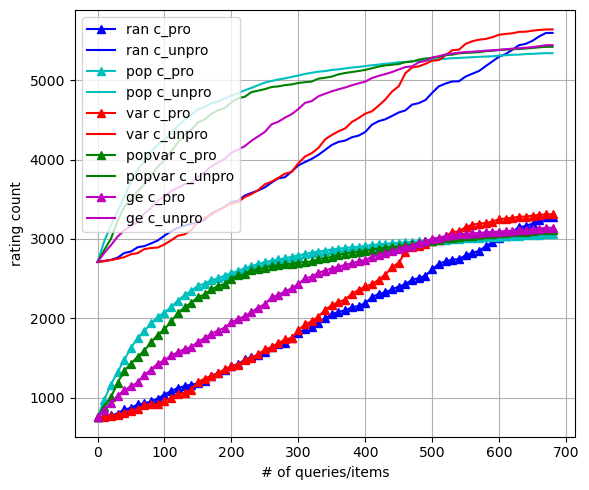

In [124]:
fig, ax = plt.subplots(figsize=(6, 5))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

# y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(y_axis, results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
    ax.plot(y_axis, results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('rating count')
# plt.title('Pro & Unpro Counts')
plt.show()
# plt.savefig('./plots/proUnpro_rate_c_ml_ratio.png', dpi=300)

# Something is off about this stupid thing!

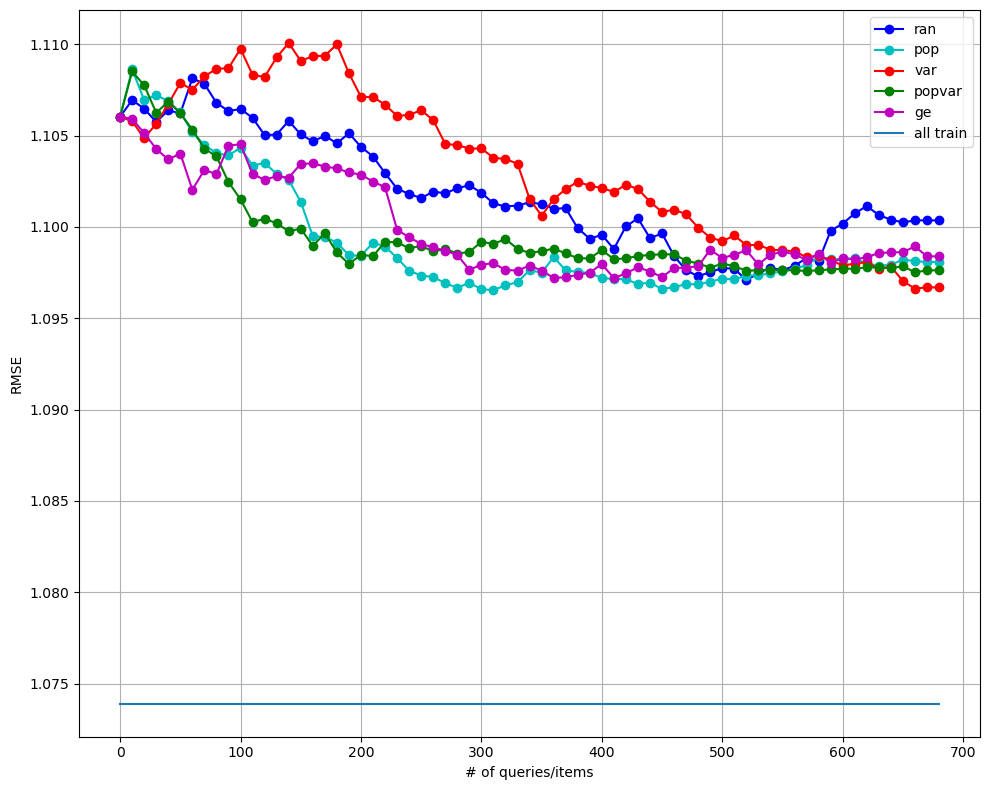

In [125]:
fig, ax = plt.subplots(figsize=(10,8))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    ax.plot(y_axis[:], results[i][1]['rmse'], m, label=results[i][0])
ax.plot(y_axis[:], [fin_acc]*len(y_axis),'-', label='all train')           
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE')
# plt.title('%s query/item at a time training'%w)

# plt.show()
plt.savefig('./plots/nonPers_rmse_diff_mc_ratio', dpi=300)

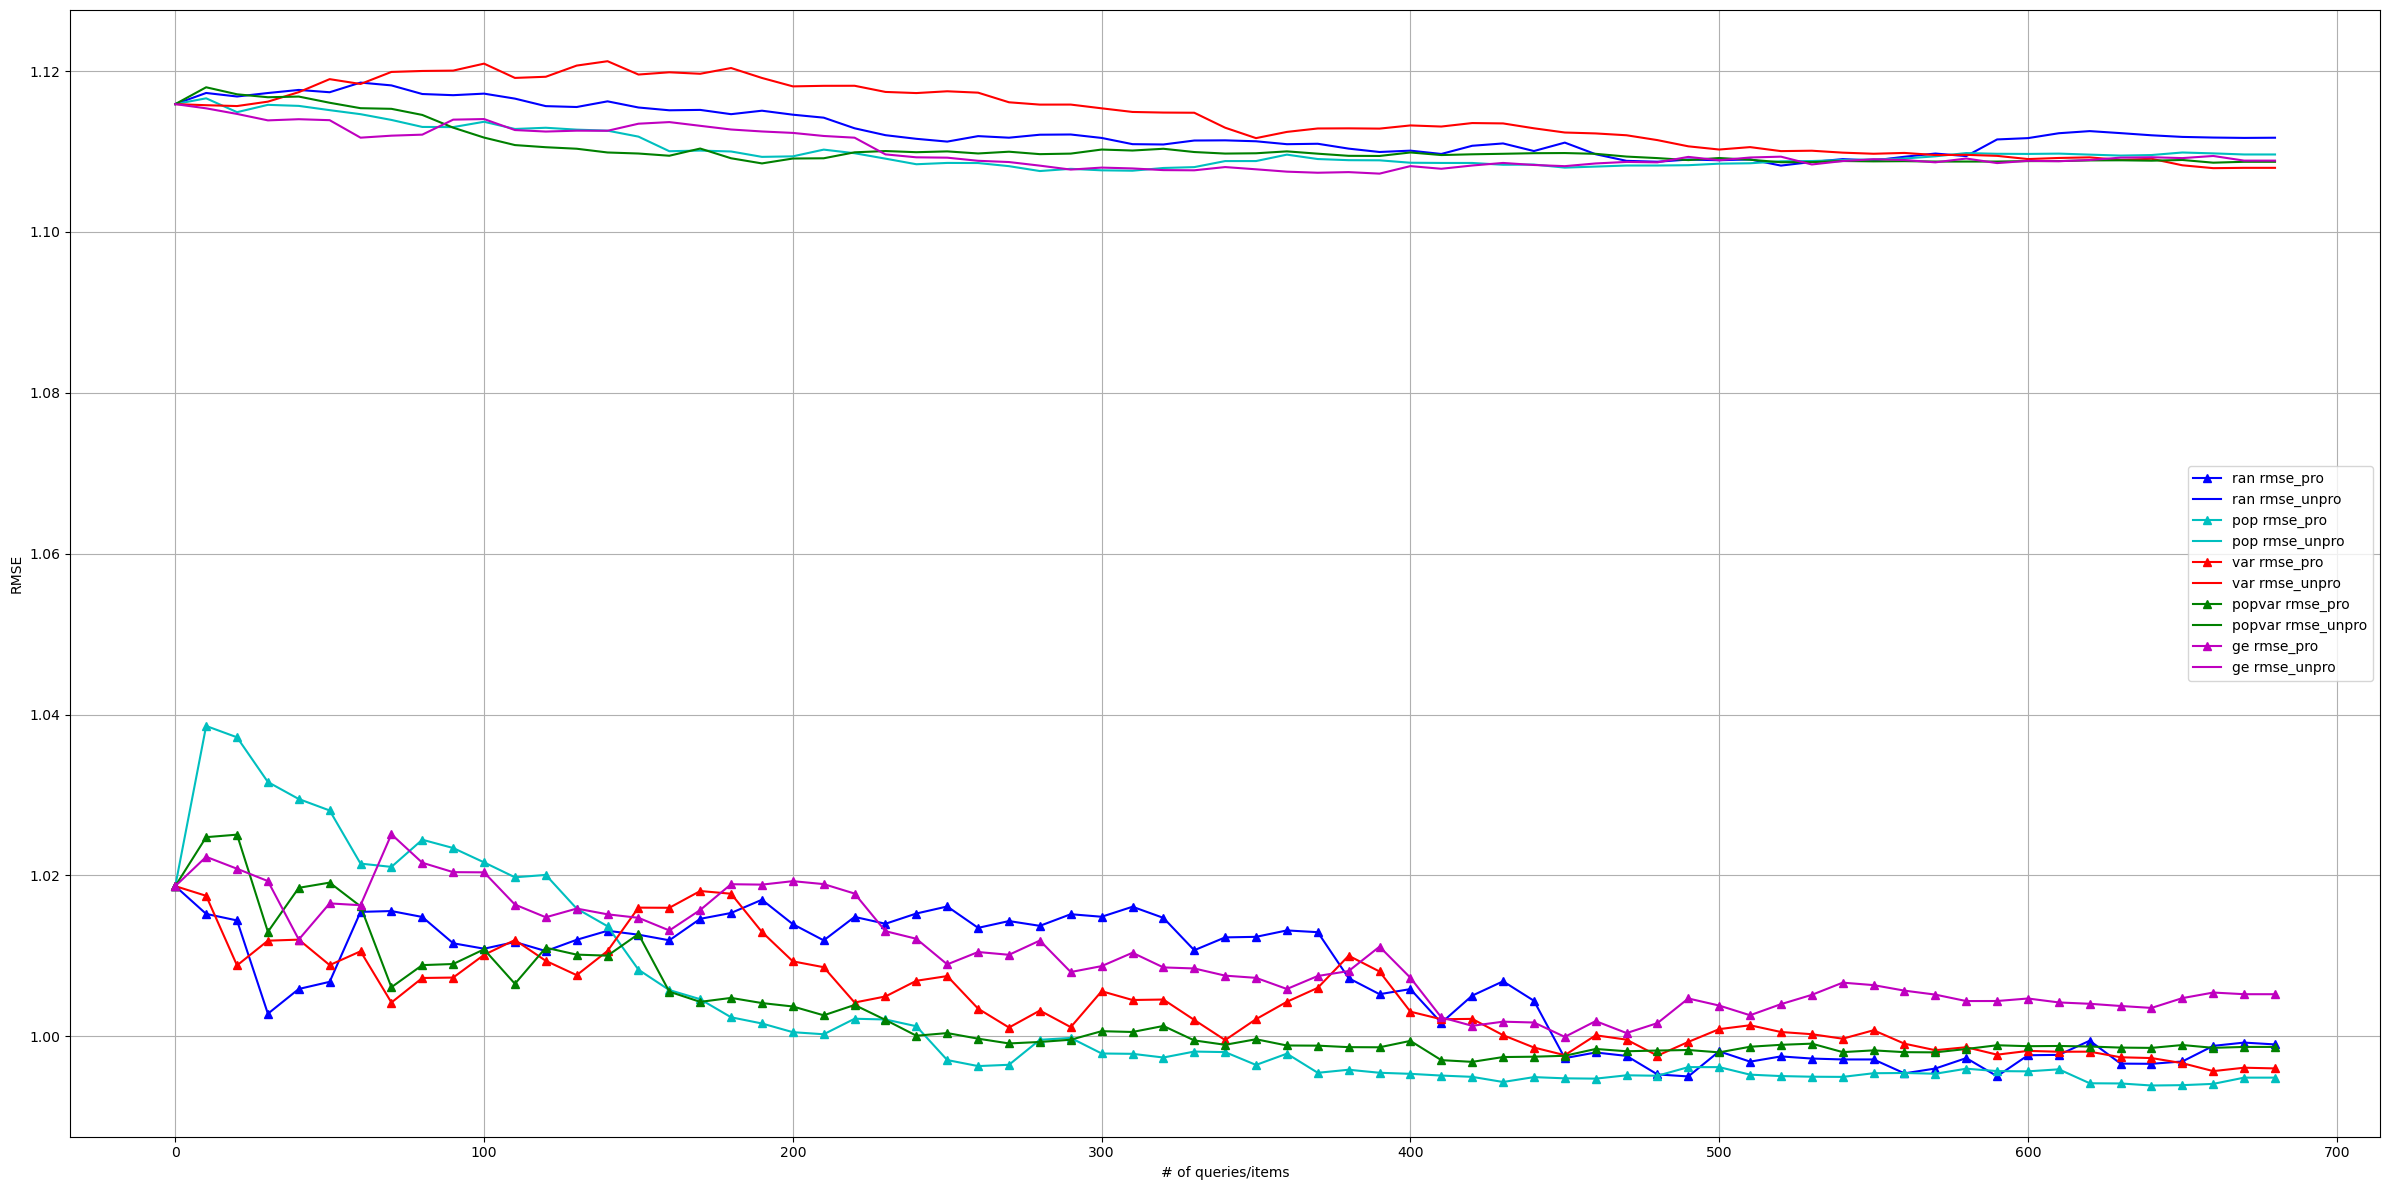

In [126]:
fig, ax = plt.subplots(figsize=(24,12))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(y_axis, results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
    ax.plot(y_axis, results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE')
# plt.title('RMSE in different AL methods')
# plt.show()
plt.savefig('./plots/proUnpro_rmse_diff_mc020424_ratio.png', dpi=300)

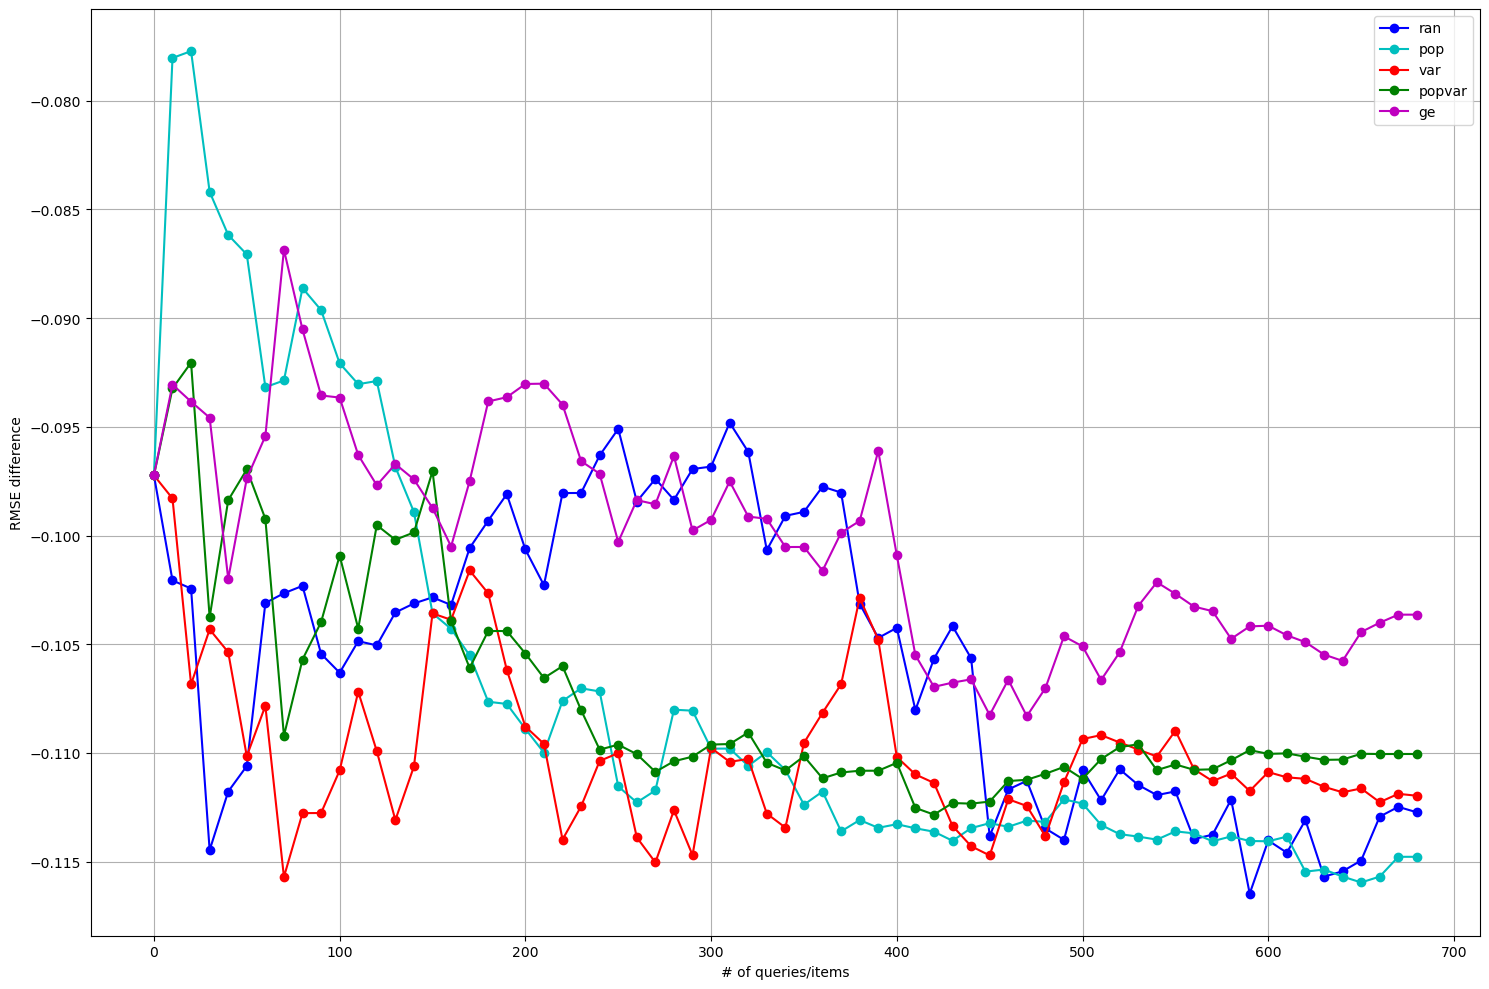

In [127]:
fig, ax = plt.subplots(figsize=(15,10))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    rmse_diff = [a-b for a, b in zip(results[i][1]['rmse_pro'], results[i][1]['rmse_unpro'])]
    ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE difference')
# plt.title('Unfairness in different AL methods')

# plt.show()
plt.savefig('./plots/rmse_diff_mc020424_ratio.png', dpi=300)